#Bibliotecas + Dados + Ajuste

Importando bibliotecas que serão utiliadas:

In [1]:
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

Vamos realiar o download da base de dados e ajustar o index em ordem crescente. Além disso, vamos renomear colunas e criar colunas de dia/mês/ano/data. Este ultimo passo é importante para verificar futuramente tendência/sazonalidade.

In [2]:
#Downlaod database
path = kagglehub.dataset_download("sumanthvrao/daily-climate-time-series-data")
db_daily_climate_train = pd.read_csv(f'{path}/DailyDelhiClimateTrain.csv', index_col='date',parse_dates = ['date'])
db_daily_climate_test = pd.read_csv(f'{path}/DailyDelhiClimateTest.csv', index_col='date',parse_dates = ['date'])

db_daily_climate = pd.concat([db_daily_climate_test,db_daily_climate_train],ignore_index=False, sort=True)

100%|██████████| 22.0k/22.0k [00:00<00:00, 35.5MB/s]

Extracting files...


In [3]:
db_daily_climate = db_daily_climate.sort_index()

In [ ]:
db_daily_climate = db_daily_climate.rename(
    {
        'meantemp':     'temp_med',
        'humidity':     'umidade',
        'wind_speed':   'vel_vento',
        'meanpressure': 'press_med'
    },
    axis = 1
)

In [ ]:
db_daily_climate['dia'] = db_daily_climate.index.day
db_daily_climate['mes'] = db_daily_climate.index.month
db_daily_climate['ano'] = db_daily_climate.index.year
db_daily_climate['data'] = db_daily_climate.index

In [ ]:
db_daily_climate

umidade    press_med   temp_med  vel_vento  dia  mes   ano  \
date                                                                       
2013-01-01  84.500000  1015.666667  10.000000   0.000000    1    1  2013   
2013-01-02  92.000000  1017.800000   7.400000   2.980000    2    1  2013   
2013-01-03  87.000000  1018.666667   7.166667   4.633333    3    1  2013   
2013-01-04  71.333333  1017.166667   8.666667   1.233333    4    1  2013   
2013-01-05  86.833333  1016.500000   6.000000   3.700000    5    1  2013   
...               ...          ...        ...        ...  ...  ...   ...   
2017-04-20  27.500000   998.625000  34.500000   5.562500   20    4  2017   
2017-04-21  39.375000   999.875000  34.250000   6.962500   21    4  2017   
2017-04-22  40.900000  1001.600000  32.900000   8.890000   22    4  2017   
2017-04-23  27.500000  1002.125000  32.875000   9.962500   23    4  2017   
2017-04-24  27.142857  1004.142857  32.000000  12.157143   24    4  2017   

                 data  
date                   
2013-01-01 2013-01-01  
2013-01-02 2013-01-02  
2013-01-03 2013-01-03  
2013-01-04 2013-01-04  
2013-01-05 2013-01-05  
...               ...  
2017-04-20 2017-04-20  
2017-04-21 2017-04-21  
2017-04-22 2017-04-22  
2017-04-23 2017-04-23  
2017-04-24 2017-04-24  

[1576 rows x 8 columns]

#Análise (Finalizado)


In [ ]:
db_daily_climate.describe().T

count                           mean                  min  \
umidade    1576.0                      60.445229            13.428571   
press_med  1576.0                    1010.593178            -3.041667   
temp_med   1576.0                      25.221918                  6.0   
vel_vento  1576.0                       6.899262                  0.0   
dia        1576.0                      15.659898                  1.0   
mes        1576.0                       6.222716                  1.0   
ano        1576.0                    2014.683376               2013.0   
data         1576  2015-02-27 10:15:50.253807104  2013-01-01 00:00:00   

                           25%                  50%                  75%  \
umidade                  49.75            62.440476               72.125   
press_med             1001.875          1009.055556               1015.2   
temp_med                  18.5            27.166667            31.142857   
vel_vento                  3.7             6.363571               9.2625   
dia                        8.0                 16.0                 23.0   
mes                        3.0                  6.0                  9.0   
ano                     2014.0               2015.0               2016.0   
data       2014-01-29 18:00:00  2015-02-27 12:00:00  2016-03-27 06:00:00   

                           max         std  
umidade                  100.0   16.979994  
press_med          7679.333333  175.242704  
temp_med             38.714286    7.345014  
vel_vento                42.22    4.510725  
dia                       31.0    8.786198  
mes                       12.0    3.502455  
ano                     2017.0    1.258118  
data       2017-04-24 00:00:00         NaN

In [ ]:
colunas = db_daily_climate.columns[:4]

for coluna in colunas:
  x = db_daily_climate[coluna].median()
  y = db_daily_climate[coluna].mean()

  print(f"{coluna}: Mediana: {x:.2f}  | Média: {y:.2f}  | Diferença: {x-y:.2f}")

#Nesse caso outliers não afetam significativamente a amostra. Poderiamos utilizar o Z-Score em caso de afetar. Nesse caso não vamos utilizar, visto que realizaremos teste mais a frente do qual suavizarão as outliers.
#Z-Score:
#informa quantos desvios padrão estamos longe da média. a medida padrão adotada é >3

umidade: Mediana: 62.44  | Média: 60.45  | Diferença: 2.00
press_med: Mediana: 1009.06  | Média: 1010.59  | Diferença: -1.54
temp_med: Mediana: 27.17  | Média: 25.22  | Diferença: 1.94
vel_vento: Mediana: 6.36  | Média: 6.90  | Diferença: -0.54


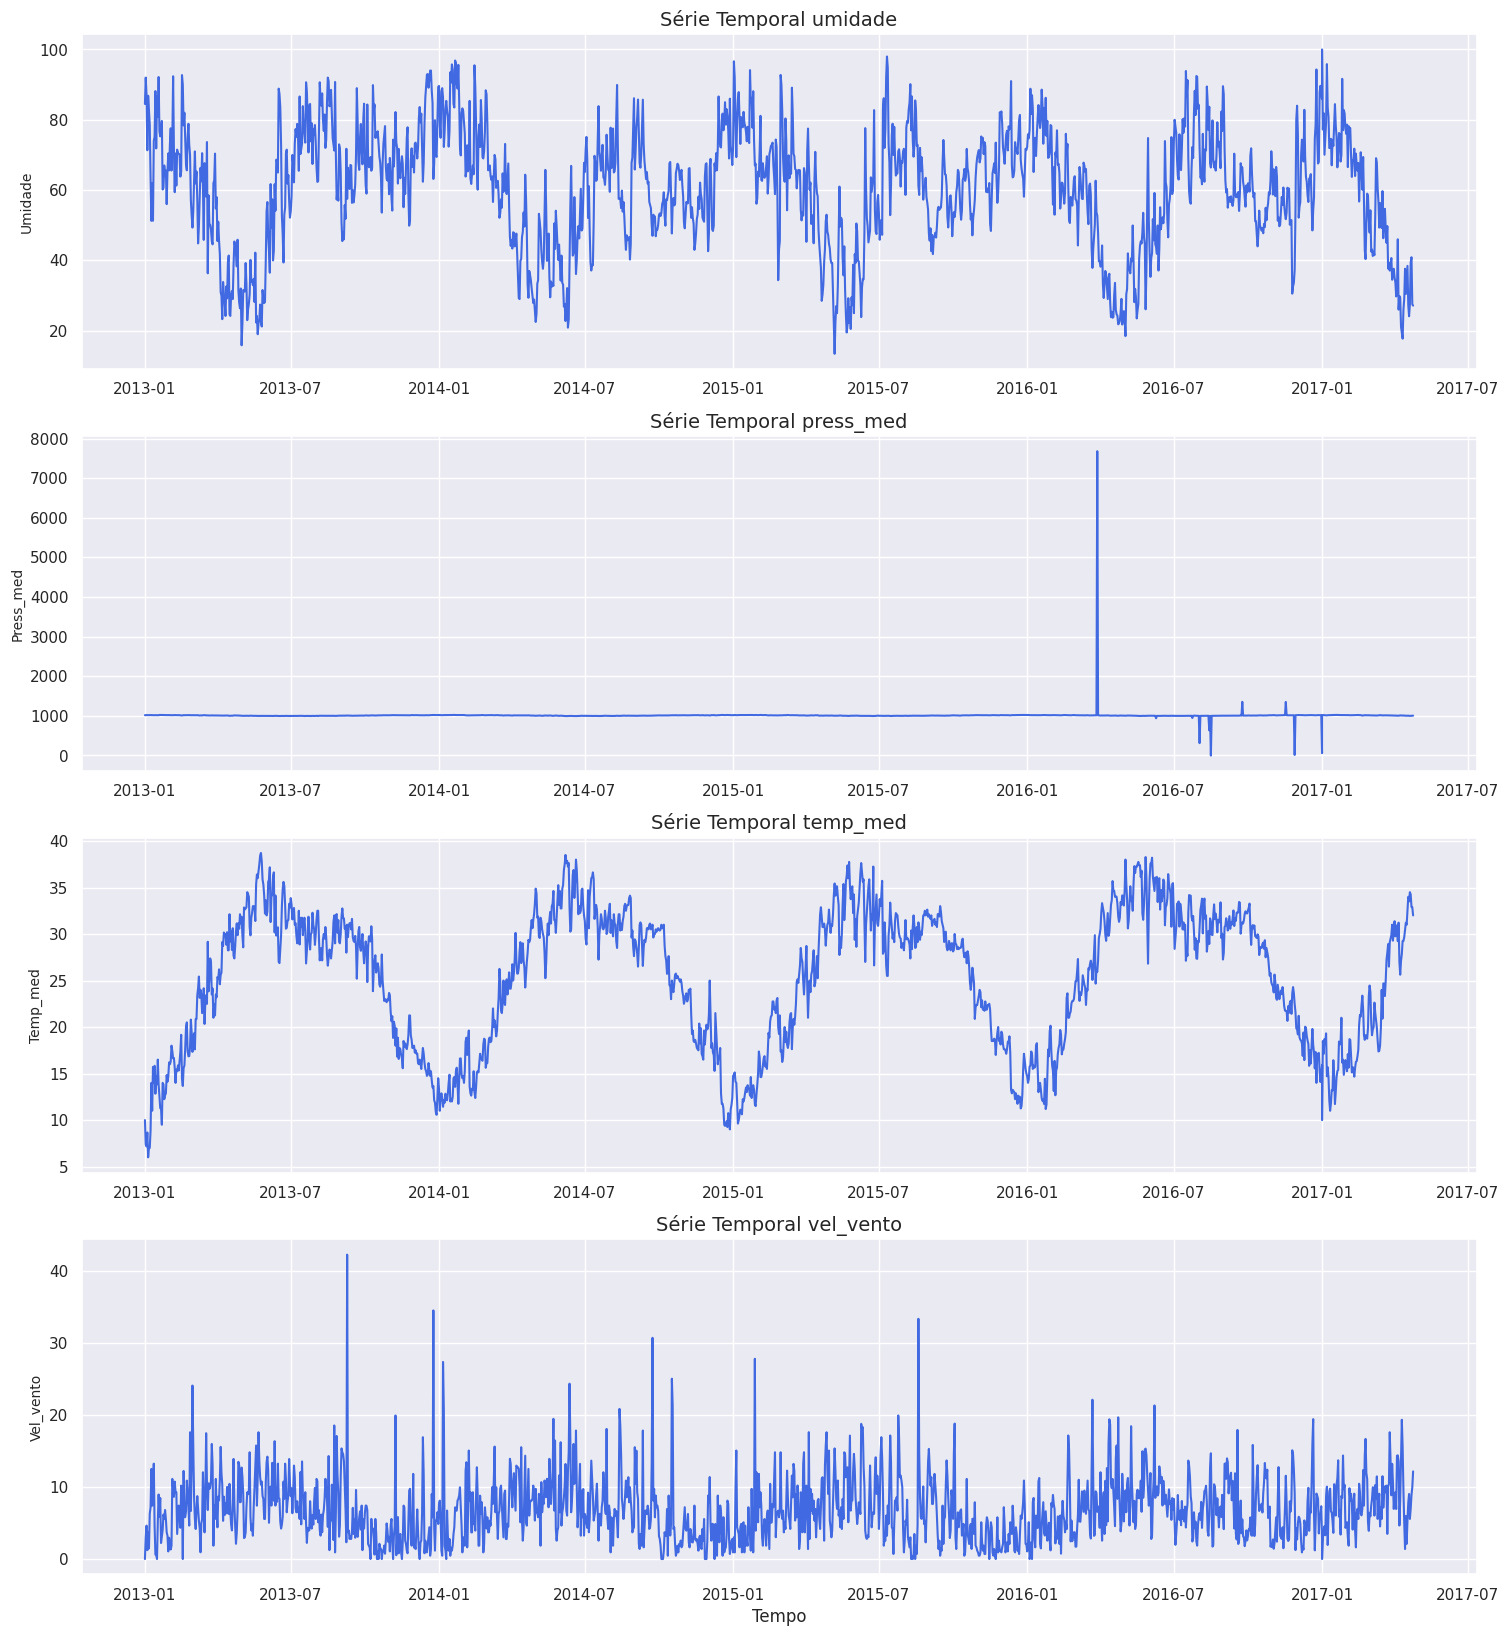

In [ ]:
colunas = db_daily_climate.columns[:4]

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(18,20))
axes = axes.flatten()

for i, coluna in enumerate(colunas):

  axes[i].plot(db_daily_climate.index, db_daily_climate[coluna], color='royalblue',linestyle='-')
  axes[i].set_title(f"Série Temporal {coluna}",fontsize=14)
  axes[i].set_ylabel(coluna.capitalize(),fontsize=10)
  if i == 3:
    axes[i].set_xlabel("Tempo",fontsize=12)

plt.show()

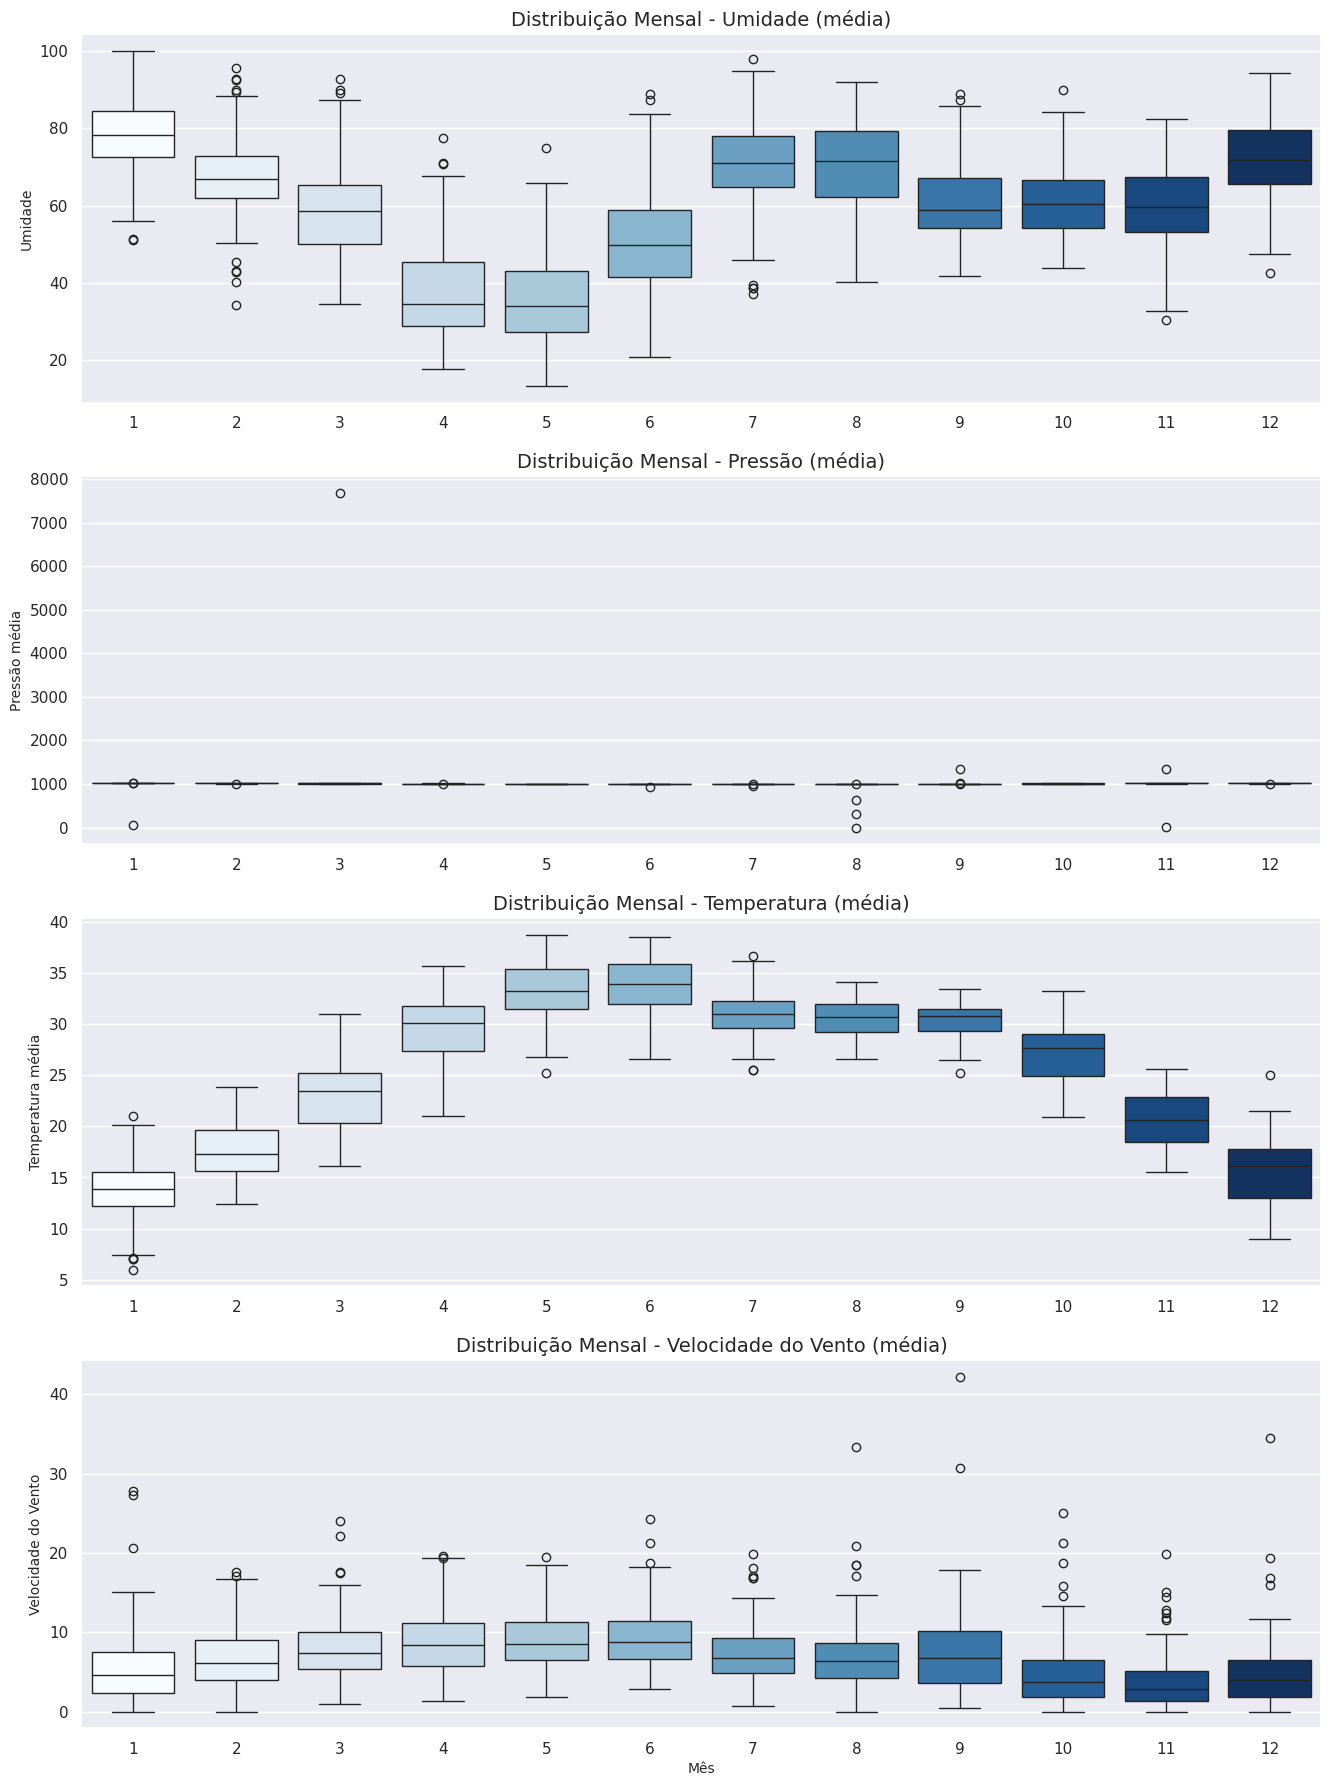

In [ ]:
#A partir dos gráficos acima, é possível verificar sazonalidade nos dados, portanto, parar verificar com clareza, vamos plotar uma

fig, axes = plt.subplots(nrows=4,ncols=1,figsize=(16,22))
ax = axes.flatten()

sns.set_theme(style="darkgrid")

sns.boxplot(x='mes',y='umidade',data=db_daily_climate,palette='Blues',hue='mes', legend=False, ax=ax[0])
ax[0].set_ylabel("Umidade",fontsize=10)
ax[0].set_xlabel("",fontsize=10)
ax[0].set_title("Distribuição Mensal - Umidade (média)",fontsize=14)

sns.boxplot(x='mes',y='press_med',data=db_daily_climate,palette='Blues',hue='mes', legend=False,ax=ax[1])
ax[1].set_ylabel("Pressão média",fontsize=10)
ax[1].set_xlabel("",fontsize=10)
ax[1].set_title("Distribuição Mensal - Pressão (média)",fontsize=14)

sns.boxplot(x='mes',y='temp_med',data=db_daily_climate,palette='Blues',hue='mes',legend=False,ax=ax[2])
ax[2].set_ylabel("Temperatura média",fontsize=10)
ax[2].set_xlabel("",fontsize=10)
ax[2].set_title("Distribuição Mensal - Temperatura (média)",fontsize=14)

sns.boxplot(x='mes',y='vel_vento',data=db_daily_climate,palette='Blues',hue='mes',legend=False,ax=ax[3])
ax[3].set_ylabel("Velocidade do Vento",fontsize=10)
ax[3].set_xlabel("Mês",fontsize=10)
ax[3].set_title("Distribuição Mensal - Velocidade do Vento (média)",fontsize=14)

plt.show()

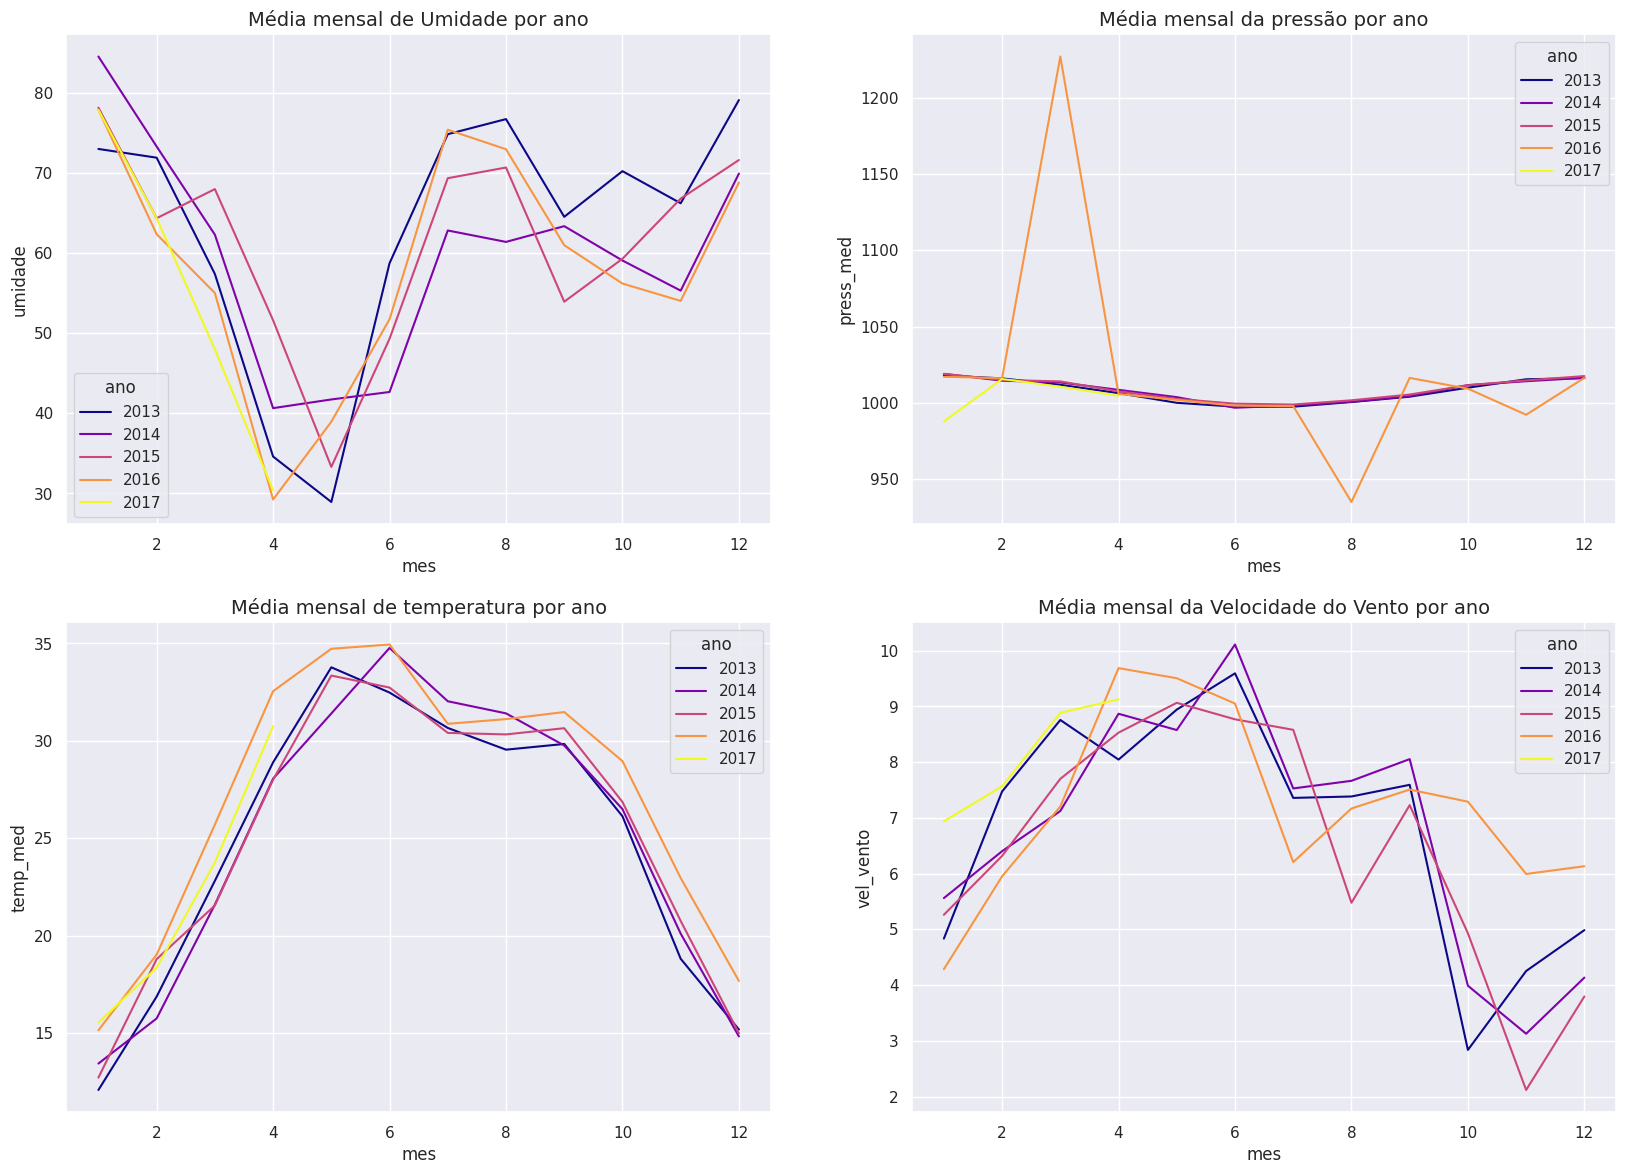

In [ ]:
#Apesar da boxplot apresentar com clareza, ainda para verificar o efeito sazonal verificamos a média mensal das variávei em cada ano

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(20,14))

sns.lineplot(data= db_daily_climate, x='mes', y='umidade', palette='plasma', hue='ano', legend=True, ax=ax[0][0], errorbar=None)
ax[0][0].set_title("Média mensal de Umidade por ano", fontsize=14)

sns.lineplot(data= db_daily_climate, x='mes', y='press_med', palette='plasma', hue='ano', legend=True, ax=ax[0][1], errorbar=None)
ax[0][1].set_title("Média mensal da pressão por ano", fontsize=14)

sns.lineplot(data= db_daily_climate, x='mes', y='temp_med', palette='plasma', hue='ano', legend=True, ax=ax[1][0], errorbar=None)
ax[1][0].set_title("Média mensal de temperatura por ano", fontsize=14)

sns.lineplot(data= db_daily_climate, x='mes', y='vel_vento', palette='plasma', hue='ano', legend=True, ax=ax[1][1], errorbar=None)
ax[1][1].set_title("Média mensal da Velocidade do Vento por ano", fontsize=14)

plt.show()


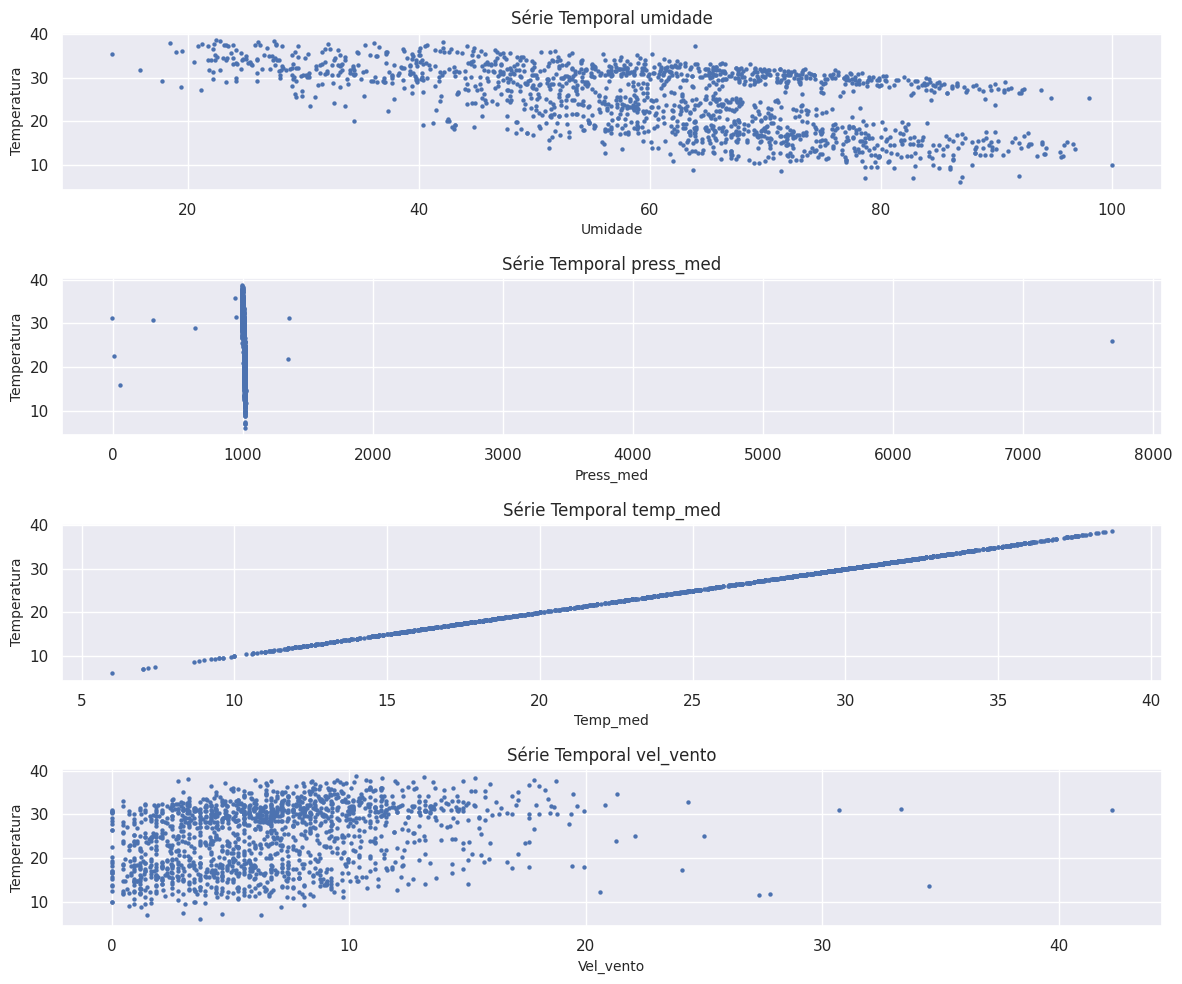

In [ ]:
#Agora que já temos certeza do efeito sazonal da série temporal, vamos verificar a correlação entre elas

colunas = db_daily_climate.columns[:4]

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12,10))
axes = axes.flatten()

for i, coluna in enumerate(colunas):
    axes[i].scatter(db_daily_climate[coluna], db_daily_climate['temp_med'], marker='o', s=10, linewidths=False)
    axes[i].set_title(f"Série Temporal {coluna}",fontsize=12)
    axes[i].set_ylabel("Temperatura",fontsize=10)
    axes[i].set_xlabel(coluna.capitalize(),fontsize=10)

plt.tight_layout()
plt.show()

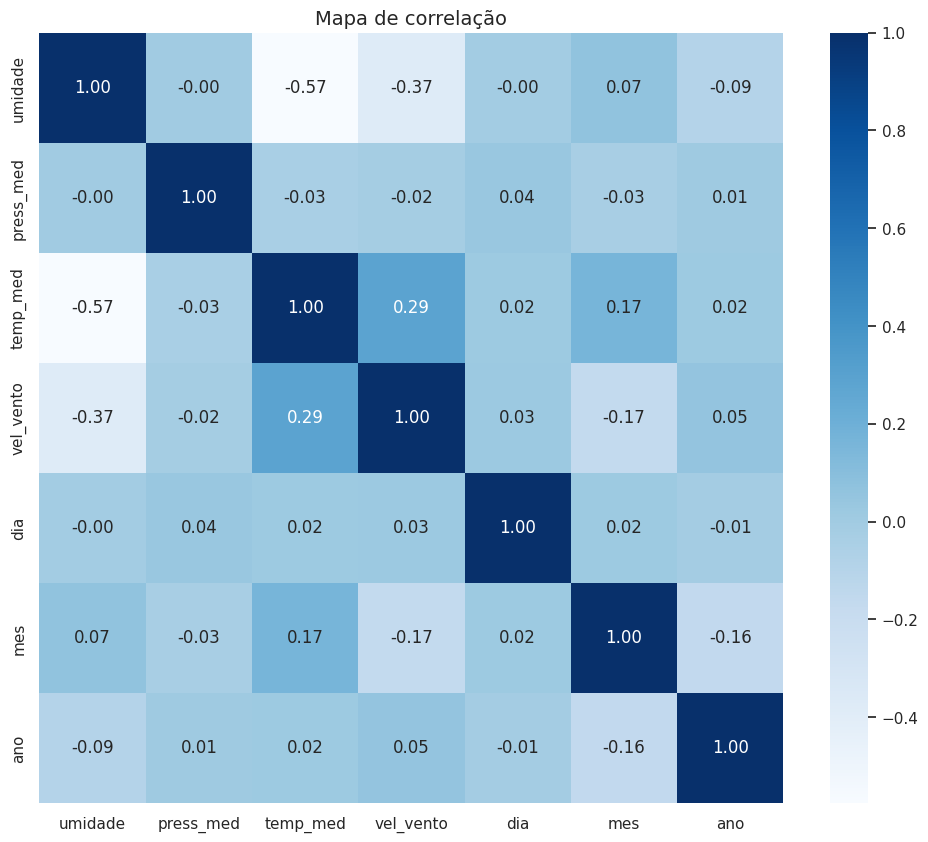

In [ ]:
plt.figure(figsize=(12,10))

sns.heatmap(db_daily_climate.select_dtypes('number').corr(), cmap='Blues',annot=True, fmt='.2f')
plt.title("Mapa de correlação",fontsize=14)

plt.show()

#Modelos de previsão - ARIMA, ARIMA com tratamento de Outliers & Random Forest

##Estacionariedade - Teste Dickey-Fuller Aumentado

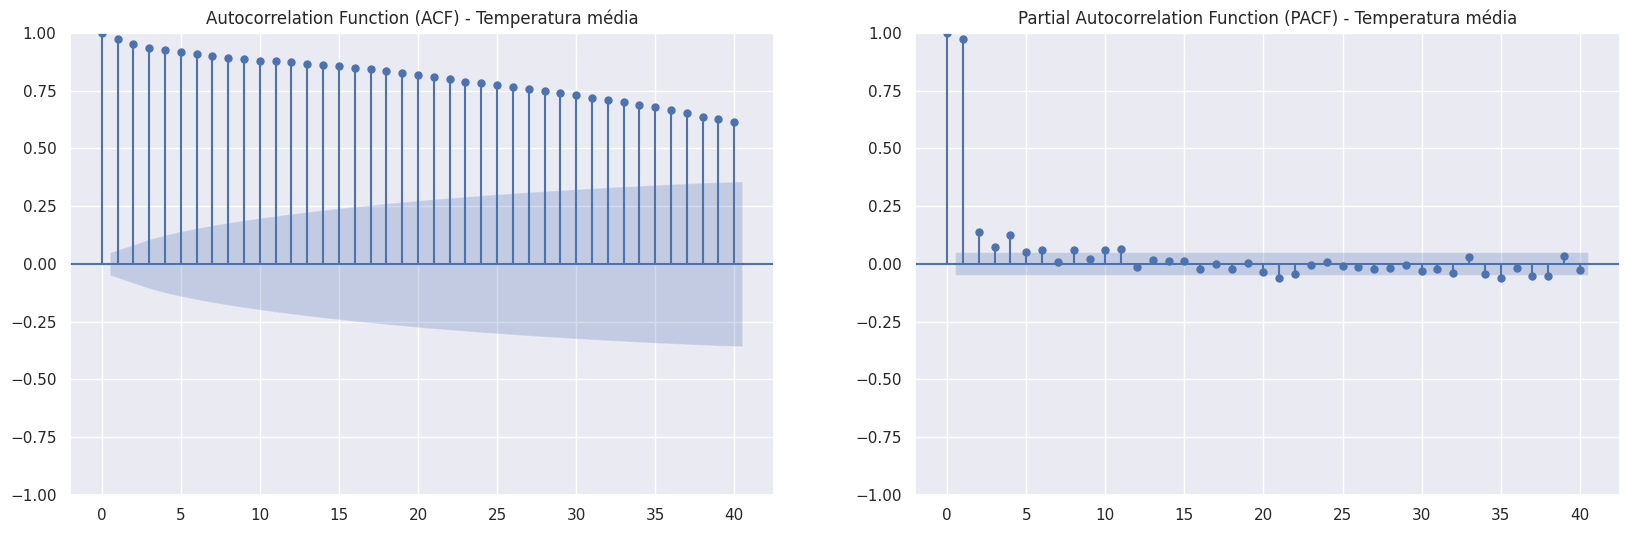

In [ ]:
#FAC e FACP
#Verificando a FAC e FACP
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20,6))

plot_acf(db_daily_climate['temp_med'], ax=ax[0], lags=40, title='Autocorrelation Function (ACF) - Temperatura média')
plot_pacf(db_daily_climate['temp_med'], ax=ax[1], lags=40, title='Partial Autocorrelation Function (PACF) - Temperatura média')

plt.show()


P-valor: 0.1475. Não rejeitamos a hipotese nula. H0: A série é não estacionária.
P-valor: 0.0000. Rejeitamos a hipotese nula. H0: A série é estacionária


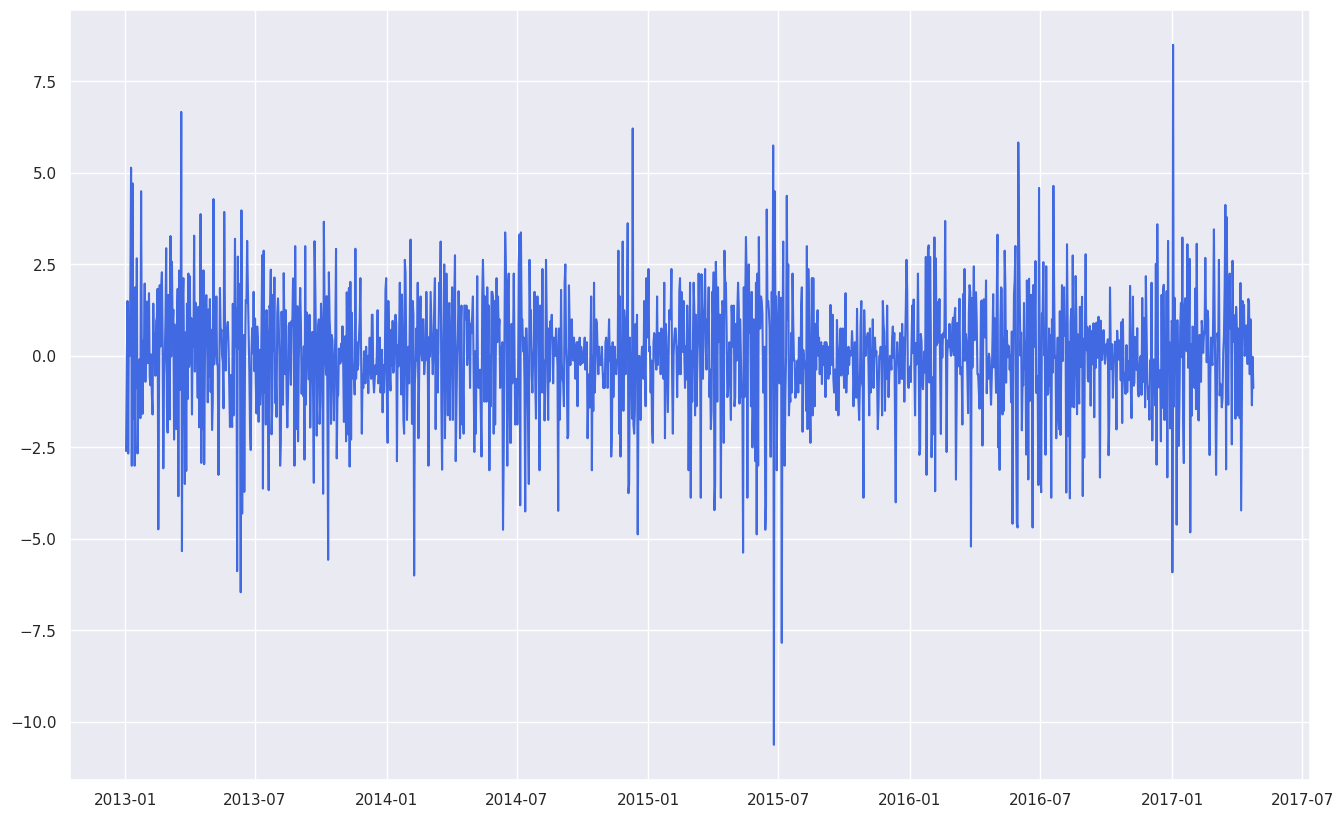

In [ ]:
#Verificando a estacionariedade da série:

db_daily_climate = db_daily_climate[['temp_med','vel_vento','umidade']]
result = adfuller(db_daily_climate['temp_med'], autolag='AIC')

if result[1] > 0.05: #adf no nível
  db_daily_climate_diff = db_daily_climate.diff()
  db_daily_climate_diff = db_daily_climate_diff.dropna()

  result_diff = adfuller(db_daily_climate_diff['temp_med'], autolag='AIC')
  print(f'P-valor: {result[1]:.4f}. Não rejeitamos a hipotese nula. H0: A série é não estacionária.')

  if result_diff[1] > 0.05: #adf na primeira diferença
    print(f'P-valor: {result_diff[1]:.4f}. Não rejeitamos a hipotese nula. H0: A série é não estacionária')
  else:
    print(f'P-valor: {result_diff[1]:.4f}. Rejeitamos a hipotese nula. H0: A série é estacionária')

    fig = plt.figure(figsize=(16,10))
    plt.plot(db_daily_climate_diff.index, db_daily_climate_diff['temp_med'], color='royalblue',linestyle='-')
    plt.show
else:
   print(f'P-valor: {result[1]:.4f}. Rejeitamos a hipotese nula. H0: A série é estacionária')

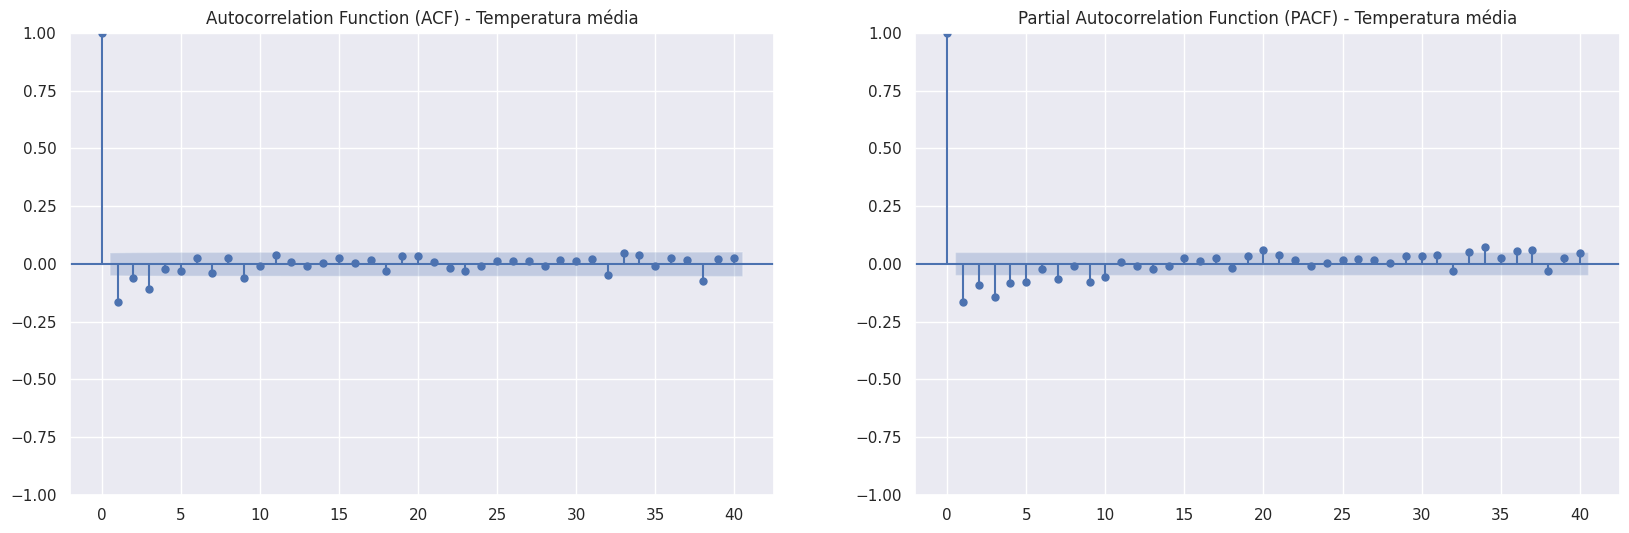

In [ ]:
#Verificando a FAC e FACP
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20,6))

plot_acf( db_daily_climate_diff['temp_med'], ax=ax[0], lags=40, title='Autocorrelation Function (ACF) - Temperatura média')
plot_pacf( db_daily_climate_diff['temp_med'], ax=ax[1], lags=40, title='Partial Autocorrelation Function (PACF) - Temperatura média')

plt.show()

#Dado os resultados, série estacionária

##Modelo ARIMA


###Modelo Multivariado

In [ ]:
db_daily_climate_train =  db_daily_climate.iloc[:round(len(db_daily_climate)*0.8)]
db_daily_climate_test = db_daily_climate.iloc[round(len(db_daily_climate)*0.8):]

In [ ]:
modelo_arima_mult = ARIMA(db_daily_climate_train['temp_med'], exog=db_daily_climate_train[['vel_vento','umidade']], order=(2,1,2))

model_arima_fit_mult = modelo_arima_mult.fit()
print(model_arima_fit_mult.summary())

#Modelo Arima
#Critérios: menor AIC

#Ljung-Box Q - autocorrelação nos resíduos do modelo. > 5% Rejeita H0 (bom).
#Jarque-Bera - distribuição normal nos resíduos. > 5% Rejeita H0 (bom)
#Heterocedasticiddade - resíduos têm variância constante (homocedasticidade). Se prob(H) > 0.05: Não há heterocedasticidade (bom sinal).
#Skew mede a assimetria dos resíduos. Valor próximo de 0: Distribuição simétrica. Valor negativo: A distribuição dos resíduos é ligeiramente inclinada à esquerda.
#Kurtosis mede a concentração dos resíduos nas caudas. Valor próximo de 3: Distribuição normal. Valor > 3: Há caudas mais pesadas do que a normal (distribuição leptocúrtica).

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               temp_med   No. Observations:                 1261
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2066.185
Date:                Sun, 23 Mar 2025   AIC                           4146.370
Time:                        23:34:31   BIC                           4182.342
Sample:                    01-01-2013   HQIC                          4159.887
                         - 06-14-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vel_vento     -0.0297      0.007     -4.413      0.000      -0.043      -0.017
umidade       -0.1365      0.004    -36.457      0.000      -0.144      -0.129
ar.L1          0.8839      0.162      5.447      0.0

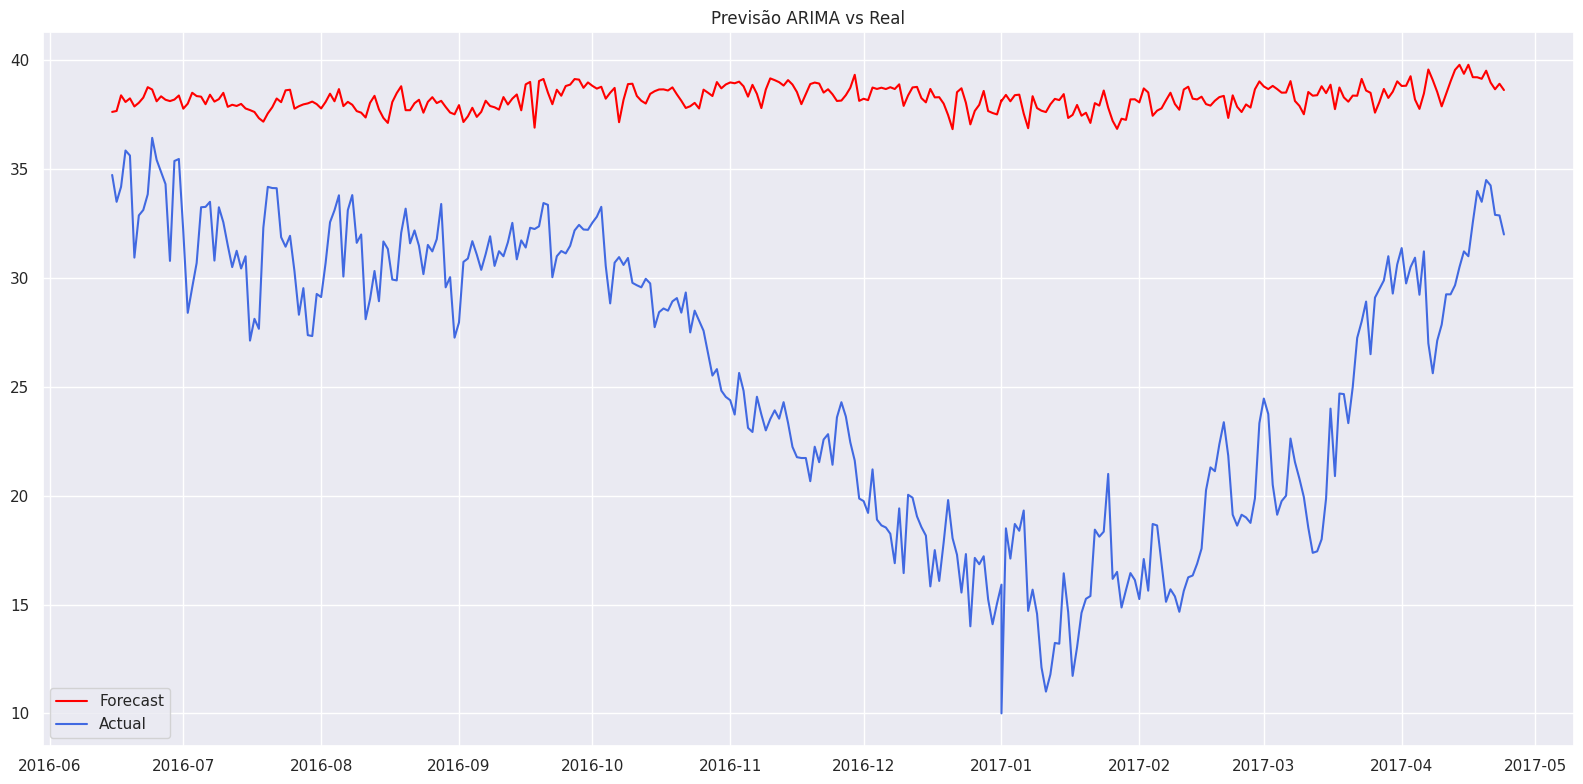

In [ ]:
previsao_arima_mult = model_arima_fit_mult.predict(start='2016-06-15',end='2017-04-25', exog=db_daily_climate_test[['umidade','vel_vento']])

mse_arima_mult = mean_squared_error(previsao_arima_mult,db_daily_climate_test['temp_med'])
rmse_arima_mult = np.sqrt(mse_arima_mult)

fig = plt.figure(figsize=(16,8))

plt.plot(db_daily_climate_test.index, previsao_arima_mult, color='red', linestyle='-', label='Forecast')
plt.plot(db_daily_climate_test.index, db_daily_climate_test['temp_med'], color='royalblue', linestyle='-', label='Actual')
plt.title('Previsão ARIMA vs Real', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

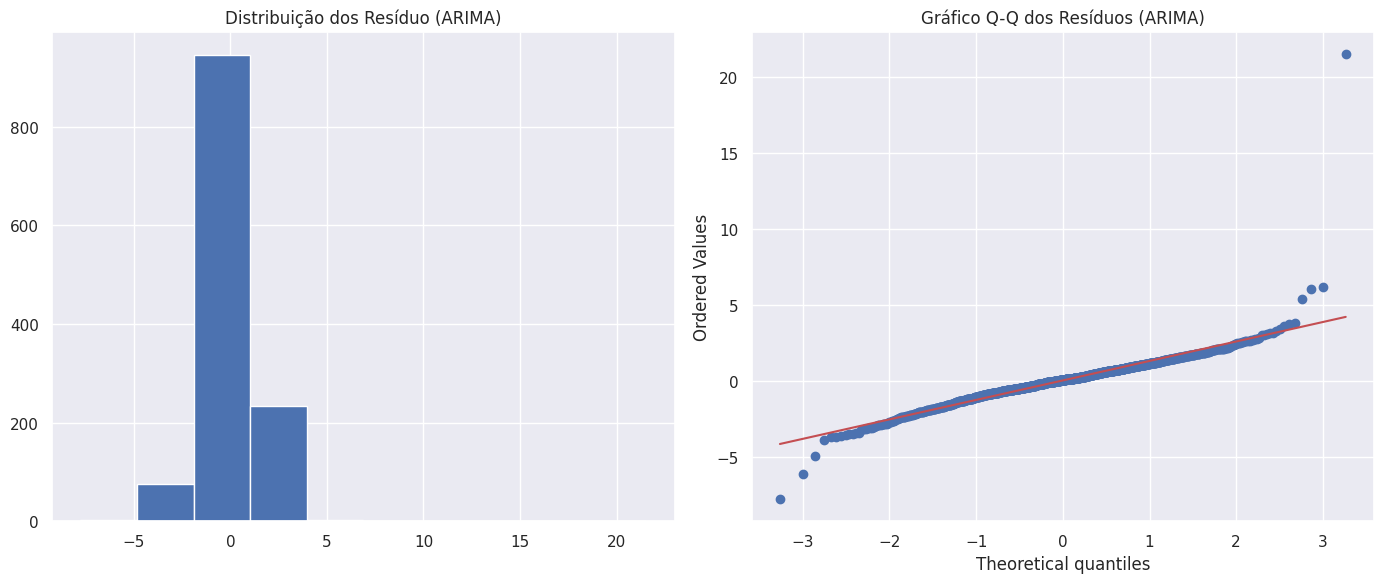

In [ ]:
arima_residuo = model_arima_fit_mult.resid

fig, ax = plt.subplots(nrows=1, ncols = 2, figsize=(14,6))

ax[0].hist(arima_residuo)
ax[0].set_title('Distribuição dos Resíduo (ARIMA)',fontsize=12)

stats.probplot(arima_residuo, dist="norm", plot=ax[1])
ax[1].set_title("Gráfico Q-Q dos Resíduos (ARIMA)",fontsize=12)

plt.tight_layout()
plt.show()

###Modelo Univariado

In [ ]:
modelo_arima_uni = ARIMA(endog= db_daily_climate_train['temp_med'], order=(2,1,1))

model_arima_uni_fit = modelo_arima_uni.fit()
print(model_arima_uni_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

                               SARIMAX Results                                
Dep. Variable:               temp_med   No. Observations:                 1261
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2398.494
Date:                Sun, 23 Mar 2025   AIC                           4804.988
Time:                        23:34:32   BIC                           4825.544
Sample:                    01-01-2013   HQIC                          4812.713
                         - 06-14-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5852      0.054     10.818      0.000       0.479       0.691
ar.L2         -0.0297      0.029     -1.015      0.310      -0.087       0.028
ma.L1         -0.7907      0.050    -15.670      0.0

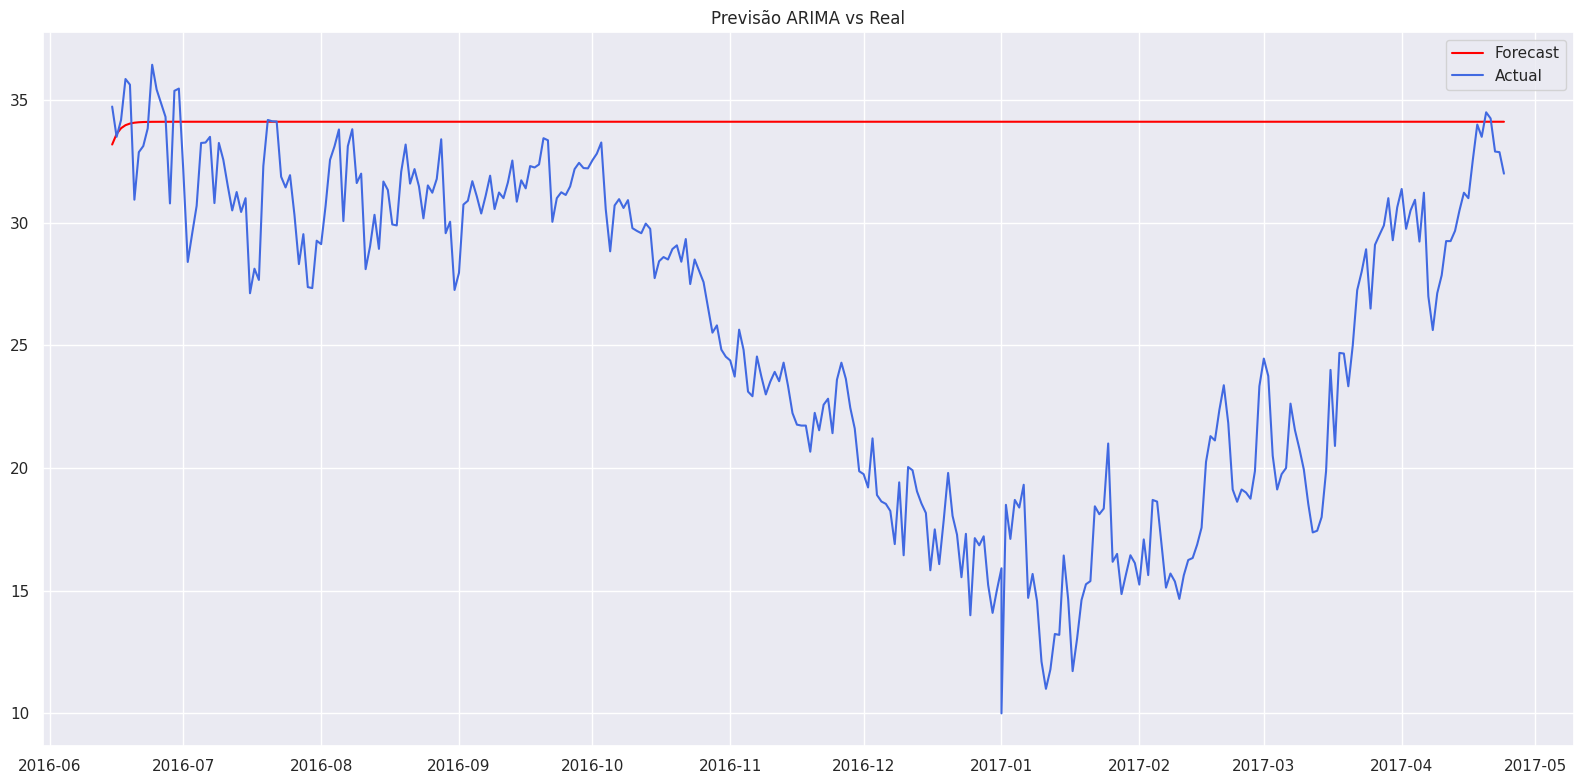

In [ ]:
previsao_arima_uni = model_arima_uni_fit.forecast(steps=len(db_daily_climate_test))

mse_arima_uni = mean_squared_error(previsao_arima_uni, db_daily_climate_test['temp_med'])
rmse_arima_uni = np.sqrt(mse_arima_uni)

fig = plt.figure(figsize=(16,8))

plt.plot(db_daily_climate_test.index, previsao_arima_uni, color='red', linestyle='-', label='Forecast')
plt.plot(db_daily_climate_test.index, db_daily_climate_test['temp_med'], color='royalblue', linestyle='-', label='Actual')
plt.title('Previsão ARIMA vs Real', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

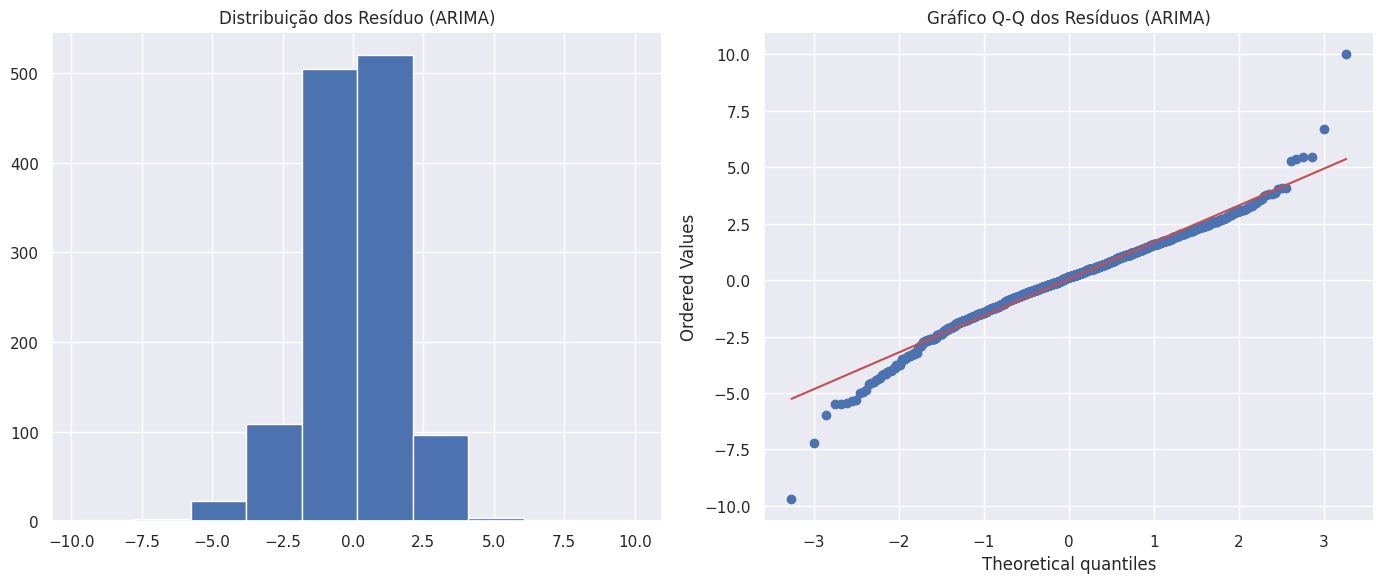

In [ ]:
arima_uni_residuo = model_arima_uni_fit.resid

fig, ax = plt.subplots(nrows=1, ncols = 2, figsize=(14,6))

ax[0].hist(arima_uni_residuo)
ax[0].set_title('Distribuição dos Resíduo (ARIMA)',fontsize=12)

stats.probplot(arima_uni_residuo, dist="norm", plot=ax[1])
ax[1].set_title("Gráfico Q-Q dos Resíduos (ARIMA)",fontsize=12)

plt.tight_layout()
plt.show()

##Z-Score - Tratamento de Outliers com ARIMA

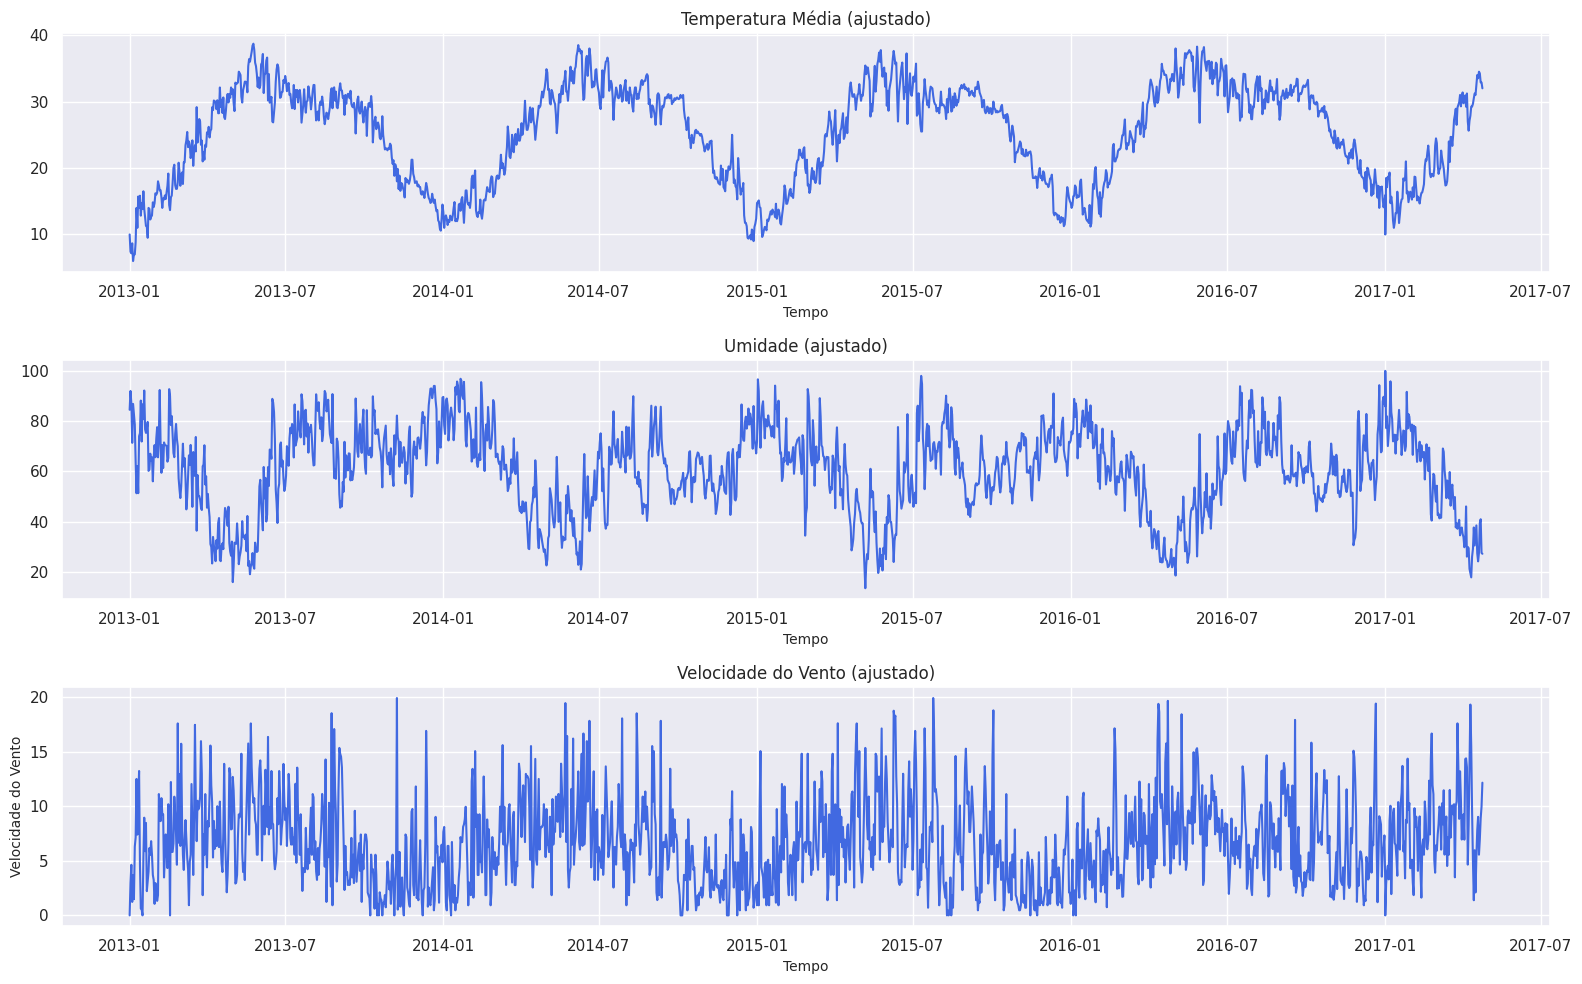

In [ ]:
#Aplicando Z-Score:
db_zscore = db_daily_climate.copy()

zscore_temp = stats.zscore(db_zscore['temp_med'])
zscore_umidade = stats.zscore(db_zscore['umidade'])
zscore_vento = stats.zscore(db_zscore['vel_vento'])

mediana_temp = np.median(db_zscore['temp_med'])
mediana_umidade = np.median(db_zscore['umidade'])
mediana_vento = np.median(db_zscore['vel_vento'])

# Substituindo os valores cujo |z-score| > 3 pela mediana
db_zscore.loc[abs(zscore_temp) > 3, 'temp_med'] = mediana_temp
db_zscore.loc[abs(zscore_umidade) > 3, 'umidade'] = mediana_umidade
db_zscore.loc[abs(zscore_vento) > 3, 'vel_vento'] = mediana_vento

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16,10))

ax[0].plot(db_zscore.index, db_zscore['temp_med'], color='royalblue', linestyle='-')
ax[0].set_title('Temperatura Média (ajustado)',fontsize=12)
ax[0].set_xlabel('Tempo',fontsize=10)

ax[1].plot(db_zscore.index, db_zscore['umidade'], color='royalblue', linestyle='-')
ax[1].set_title('Umidade (ajustado)',fontsize=12)
ax[1].set_xlabel('Tempo',fontsize=10)

ax[2].plot(db_zscore.index, db_zscore['vel_vento'], color='royalblue', linestyle='-')
ax[2].set_title('Velocidade do Vento (ajustado)',fontsize=12)
ax[2].set_xlabel('Tempo',fontsize=10)
ax[2].set_ylabel('Velocidade do Vento',fontsize=10)

plt.tight_layout()
plt.show()

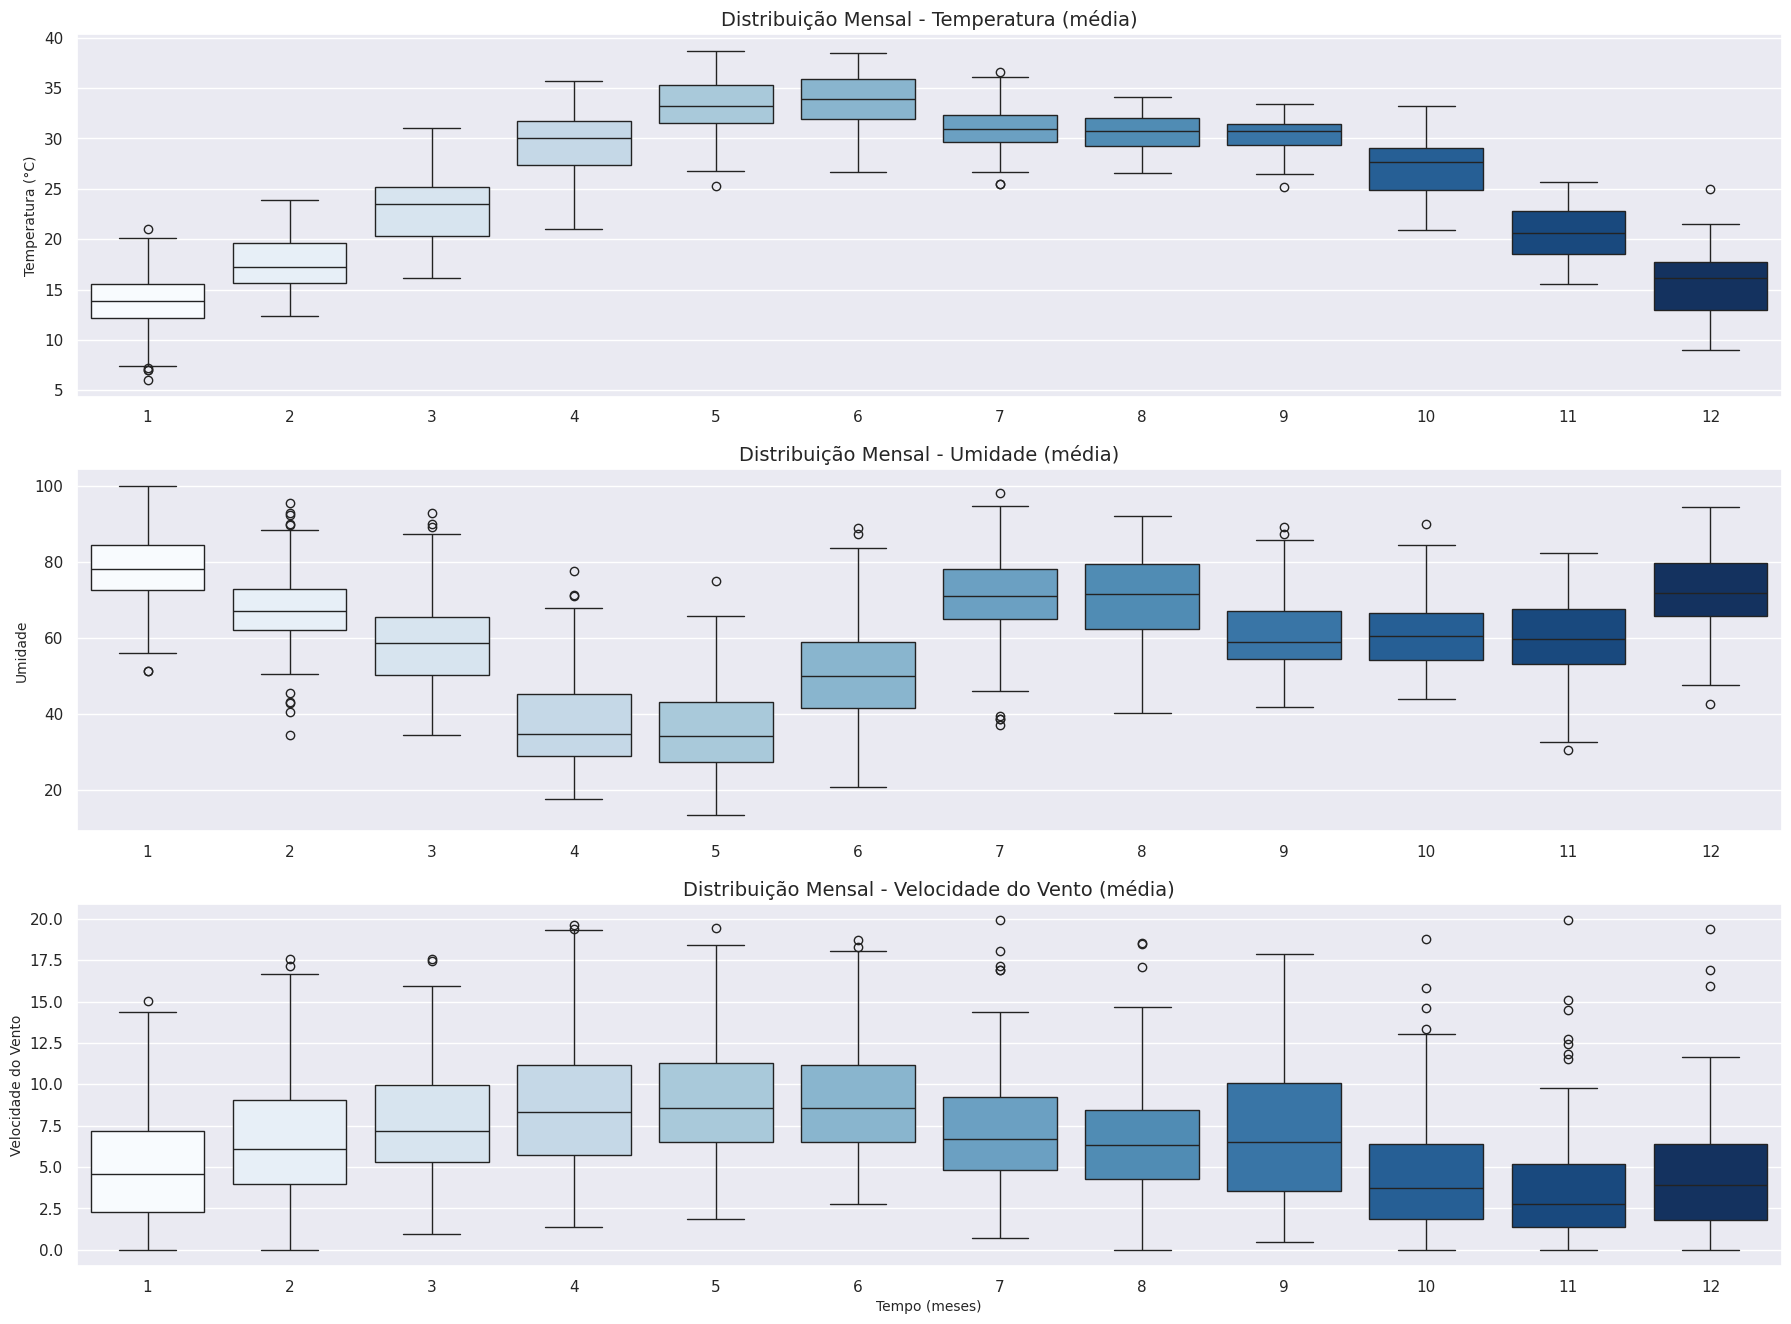

In [ ]:
db_zscore['mes'] = db_zscore.index.month

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(22,16))

sns.set_theme(style="darkgrid")
sns.boxplot(x='mes',y='temp_med',data=db_zscore,palette='Blues',hue='mes', legend=False,ax=ax[0])
ax[0].set_ylabel("Temperatura (°C)",fontsize=10)
ax[0].set_xlabel("",fontsize=10)
ax[0].set_title("Distribuição Mensal - Temperatura (média)",fontsize=14)

sns.boxplot(x='mes',y='umidade',data=db_zscore,palette='Blues',hue='mes', legend=False,ax=ax[1])
ax[1].set_ylabel("Umidade",fontsize=10)
ax[1].set_xlabel("",fontsize=10)
ax[1].set_title("Distribuição Mensal - Umidade (média)",fontsize=14)

sns.boxplot(x='mes',y='vel_vento',data=db_zscore,palette='Blues',hue='mes', legend=False,ax=ax[2])
ax[2].set_ylabel("Velocidade do Vento",fontsize=10)
ax[2].set_xlabel("Tempo (meses)",fontsize=10)
ax[2].set_title("Distribuição Mensal - Velocidade do Vento (média)",fontsize=14)

plt.show()

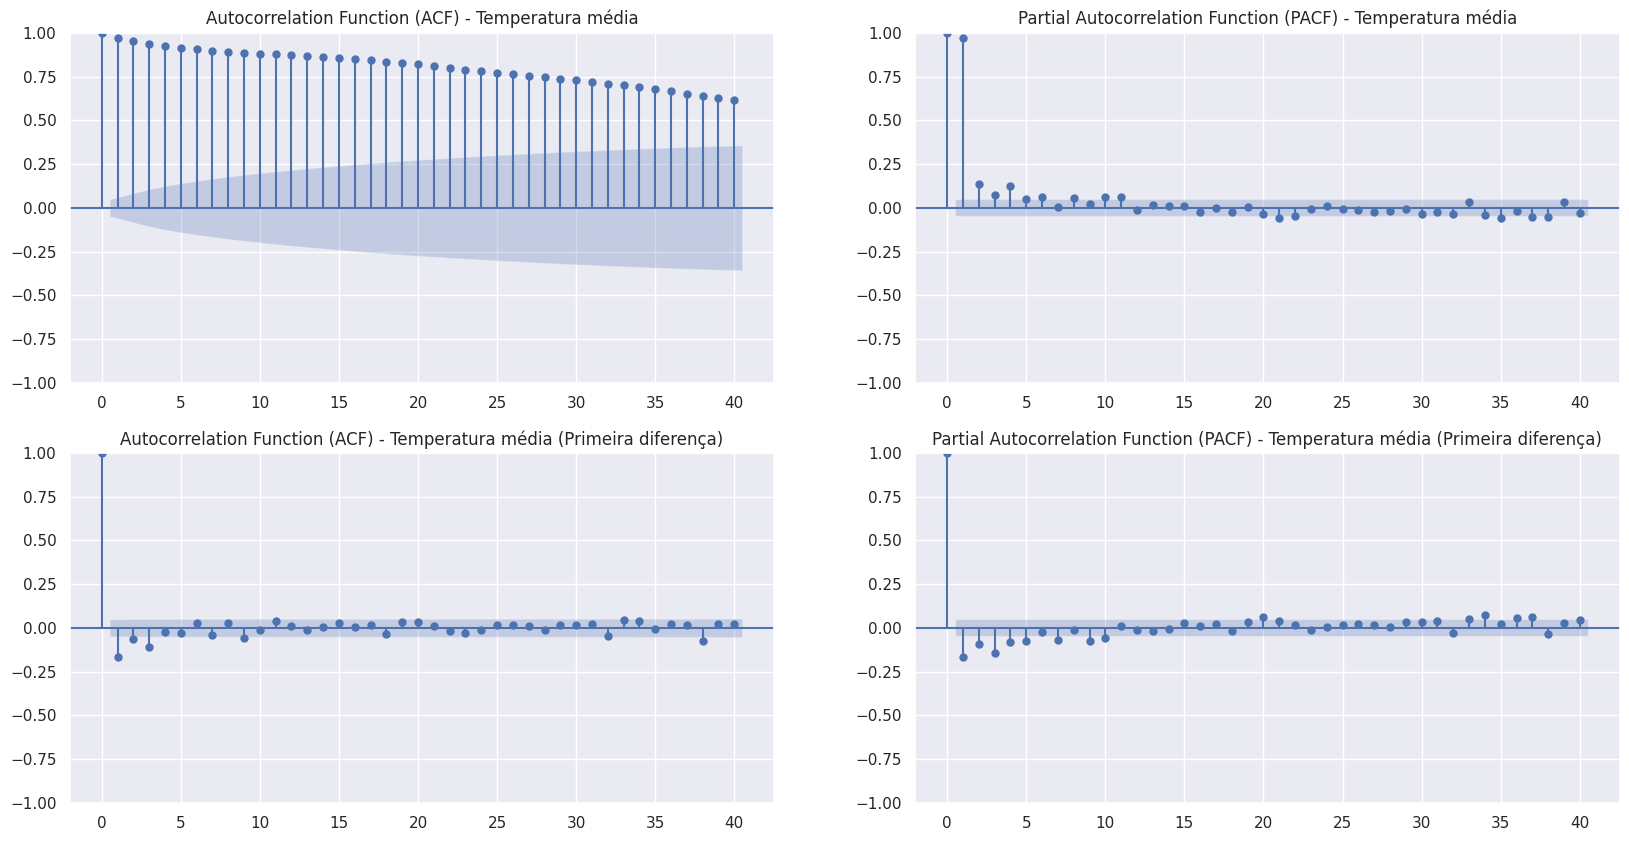

In [ ]:
#Tirando a diferença
db_zscore_diff = db_zscore.diff()
db_zscore_diff = db_zscore_diff.dropna()

#Verificando a FAC e FACP
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(20,10))

plot_acf(db_zscore['temp_med'], ax=ax[0][0], lags=40, title='Autocorrelation Function (ACF) - Temperatura média')
plot_pacf(db_zscore['temp_med'], ax=ax[0][1], lags=40, title='Partial Autocorrelation Function (PACF) - Temperatura média')
plot_acf(db_zscore_diff['temp_med'], ax=ax[1][0], lags=40, title='Autocorrelation Function (ACF) - Temperatura média (Primeira diferença)')
plot_pacf(db_zscore_diff['temp_med'], ax=ax[1][1], lags=40, title='Partial Autocorrelation Function (PACF) - Temperatura média (Primeira diferença)')

plt.show()

In [ ]:
db_zscore_train = db_zscore[:round(len(db_daily_climate)*0.8)]
db_zscore_test = db_zscore[round(len(db_daily_climate)*0.8):]

zscore_arima = ARIMA(db_zscore_train['temp_med'], exog=db_zscore_train[['vel_vento','umidade']], order=(1,1,2))
zscore_arima_fit = zscore_arima.fit()
print(zscore_arima_fit.summary())

#Ljung-Box Q - autocorrelação nos resíduos do modelo. > 5% Rejeita H0 (bom).
#Jarque-Bera - distribuição normal nos resíduos. > 5% Rejeita H0 (bom)
#Heterocedasticiddade - resíduos têm variância constante (homocedasticidade). Se prob(H) > 0.05: Não há heterocedasticidade (bom sinal).
#Skew mede a assimetria dos resíduos. Valor próximo de 0: Distribuição simétrica. Valor negativo: A distribuição dos resíduos é ligeiramente inclinada à esquerda.
#Kurtosis mede a concentração dos resíduos nas caudas. Valor próximo de 3: Distribuição normal. Valor > 3: Há caudas mais pesadas do que a normal (distribuição leptocúrtica).

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               temp_med   No. Observations:                 1261
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2068.397
Date:                Sun, 23 Mar 2025   AIC                           4148.793
Time:                        23:34:37   BIC                           4179.627
Sample:                    01-01-2013   HQIC                          4160.380
                         - 06-14-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vel_vento     -0.0371      0.009     -4.187      0.000      -0.054      -0.020
umidade       -0.1361      0.004    -36.789      0.000      -0.143      -0.129
ar.L1          0.5609      0.068      8.250      0.0

In [ ]:
db_zscore_test_diff = db_zscore_test.diff()
db_zscore_test_diff = db_zscore_test_diff.dropna()

previsao_arima_zscore = zscore_arima_fit.predict(start=db_zscore_test_diff.index[0],end=db_zscore_test_diff.index[-1],exog=db_zscore_test_diff[['umidade','vel_vento']])

y_pred_zscore = db_zscore_test['temp_med'].iloc[2:]

mse_arima_zscore = mean_squared_error(y_pred_zscore, previsao_arima_zscore)
rmse_arima_zscore = np.sqrt(mse_arima_zscore)

2016-06-16    41.325930
2016-06-17    40.575424
2016-06-18    41.170159
2016-06-19    40.589624
2016-06-20    41.409565
                ...    
2017-04-20    41.529370
2017-04-21    40.552283
2017-04-22    40.864275
2017-04-23    41.534104
2017-04-24    40.897704
Freq: D, Name: predicted_mean, Length: 313, dtype: float64

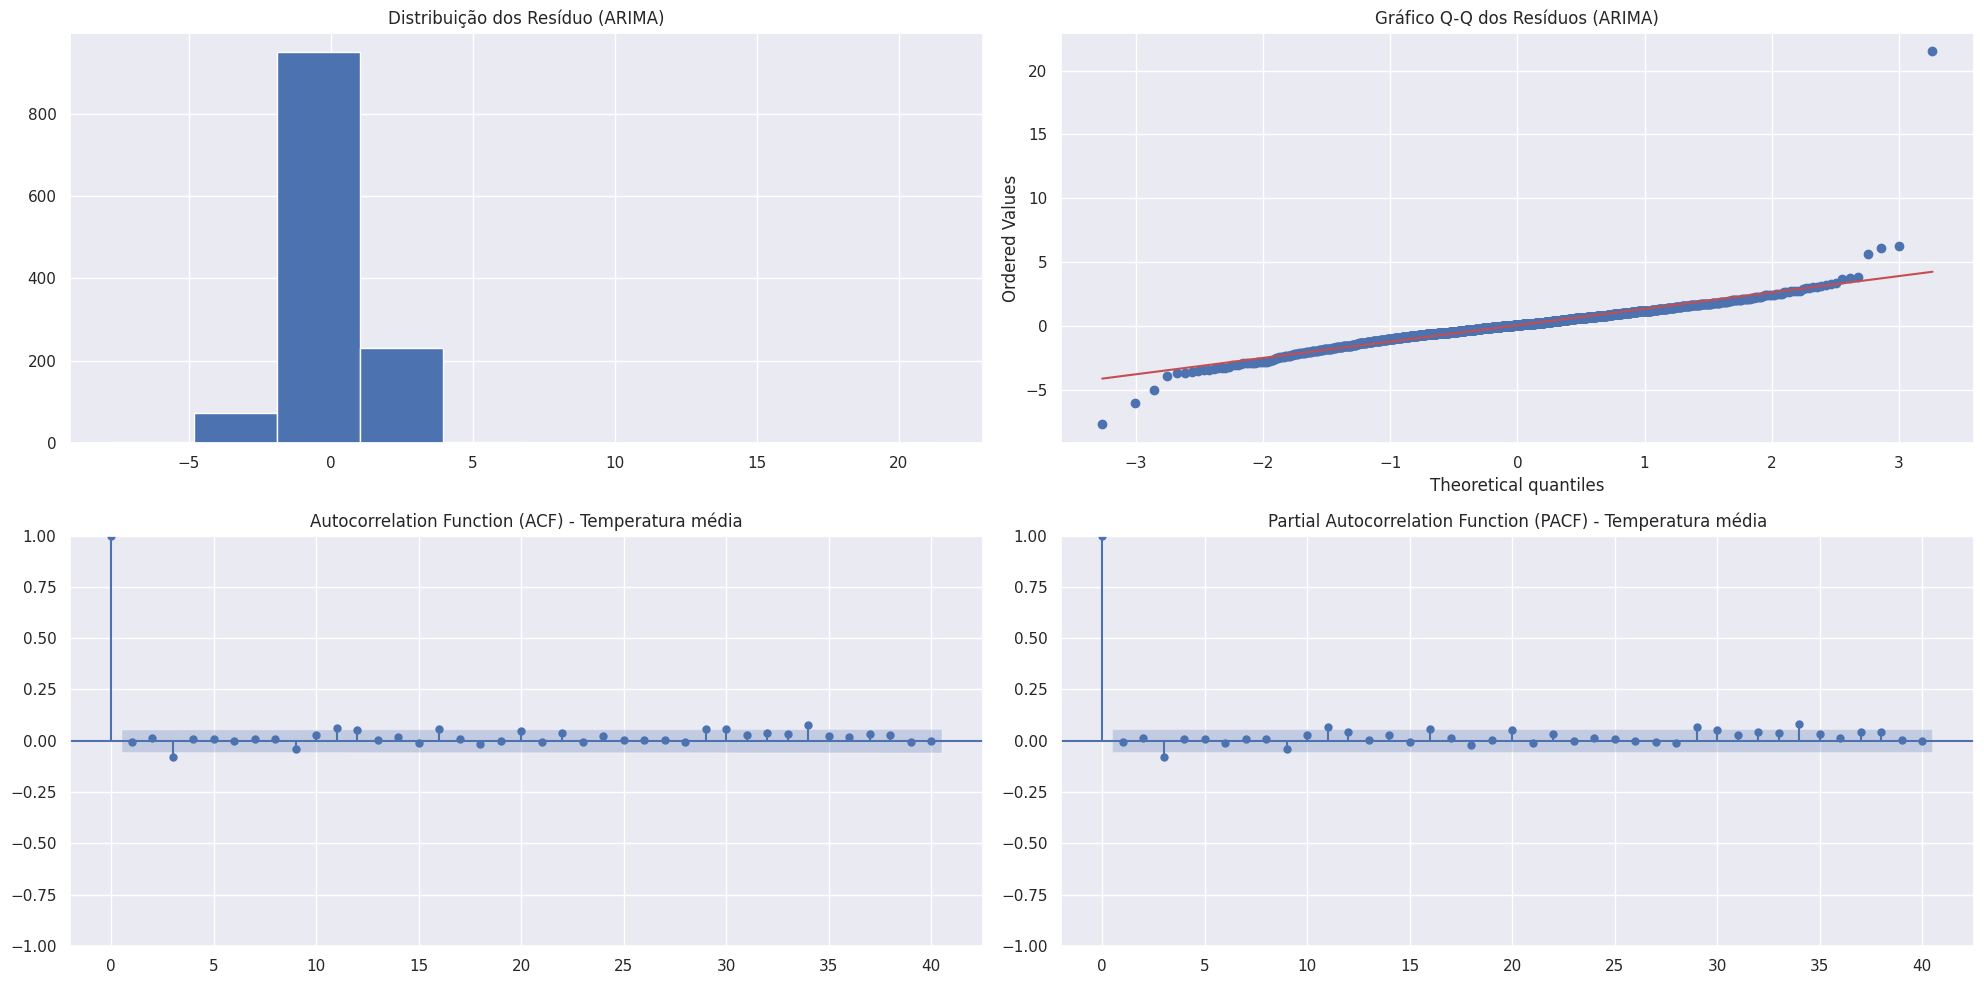

In [ ]:
zscore_arima_residuo = zscore_arima_fit.resid

fig, ax = plt.subplots(nrows=2, ncols = 2, figsize=(20,10))

ax[0][0].hist(zscore_arima_residuo)
ax[0][0].set_title('Distribuição dos Resíduo (ARIMA)',fontsize=12)

stats.probplot(zscore_arima_residuo, dist="norm", plot=ax[0][1])
ax[0][1].set_title("Gráfico Q-Q dos Resíduos (ARIMA)",fontsize=12)

plot_acf(zscore_arima_residuo, ax=ax[1][0], lags=40, title='Autocorrelation Function (ACF) - Temperatura média')

plot_pacf(zscore_arima_residuo, ax=ax[1][1], lags=40, title='Partial Autocorrelation Function (PACF) - Temperatura média')

plt.tight_layout()
plt.show()

##Método IQR no tratamento de Outliers

In [ ]:
db_daily_climate_iqr = db_daily_climate.copy()
db_daily_climate_filtro = db_daily_climate.copy()

Q1 = db_daily_climate_iqr.quantile(0.25)
Q3 = db_daily_climate_iqr.quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1 * IQR
limite_superior = Q3 + 1 * IQR

db_daily_climate_filtro['temp_med'] = (db_daily_climate_iqr['temp_med'] >= limite_inferior.iloc[0]) & (db_daily_climate_iqr['temp_med'] <= limite_superior.iloc[0])
db_daily_climate_filtro['vel_vento'] = (db_daily_climate_iqr['vel_vento'] >= limite_inferior.iloc[1]) & (db_daily_climate_iqr['vel_vento'] <= limite_superior.iloc[1])
db_daily_climate_filtro['umidade'] = (db_daily_climate_iqr['umidade'] >= limite_inferior.iloc[2]) & (db_daily_climate_iqr['umidade'] <= limite_superior.iloc[2])

db_daily_climate_iqr = db_daily_climate_iqr[db_daily_climate_filtro]
db_daily_climate_iqr = db_daily_climate_iqr.dropna()

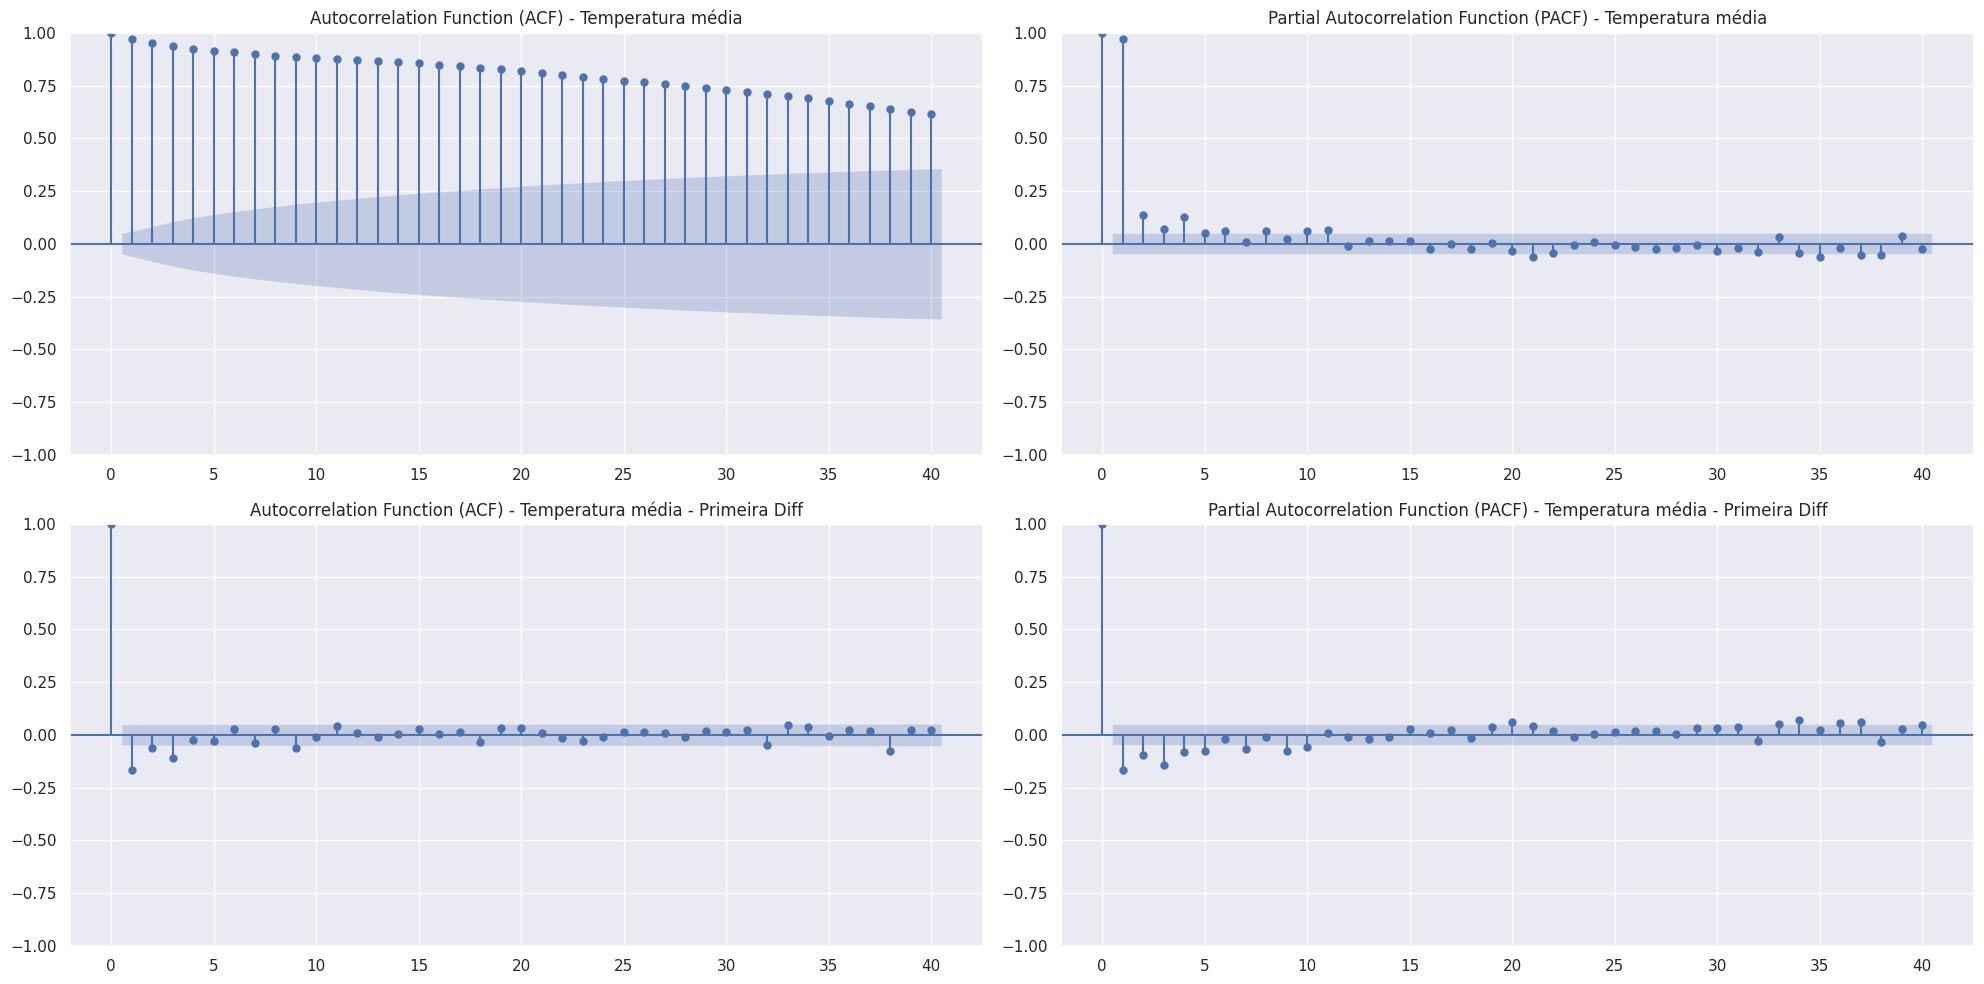

In [ ]:
#FAC e FACP

db_iqr_diff = db_daily_climate_iqr[['temp_med','vel_vento','umidade']].diff()
db_iqr_diff = db_zscore_diff.dropna()

#Verificando a FAC e FACP
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(20,10))

plot_acf(db_daily_climate['temp_med'], ax=ax[0][0], lags=40, title='Autocorrelation Function (ACF) - Temperatura média')
plot_pacf(db_daily_climate['temp_med'], ax=ax[0][1], lags=40, title='Partial Autocorrelation Function (PACF) - Temperatura média')
plot_acf(db_iqr_diff['temp_med'], ax=ax[1][0], lags=40, title='Autocorrelation Function (ACF) - Temperatura média - Primeira Diff')
plot_pacf(db_iqr_diff['temp_med'], ax=ax[1][1], lags=40, title='Partial Autocorrelation Function (PACF) - Temperatura média - Primeira Diff')

plt.tight_layout()
plt.show()

In [ ]:
db_daily_climate_iqr['mes'] = db_daily_climate_iqr.index.month

x = db_daily_climate_iqr['mes'].unique()

map_mes = {
    1:   "Inverno",
    2:   "Primavera",
    3:   "Primavera",
    4:   "Verão",
    5:   "Verão",
    6:   "Monções",
    7:   "Monções",
    8:   "Monções",
    9:   "Outono",
    10:  "Outono",
    11:  "Inverno",
    12:  "Inverno"
}

db_daily_climate_iqr['estacao_ano'] = db_daily_climate_iqr['mes'].map(map_mes)
dummies_estacao = pd.get_dummies(db_daily_climate_iqr['estacao_ano'], prefix='estacao_ano').astype(int)
db_daily_climate_iqr = pd.concat([db_daily_climate_iqr, dummies_estacao], axis=1)

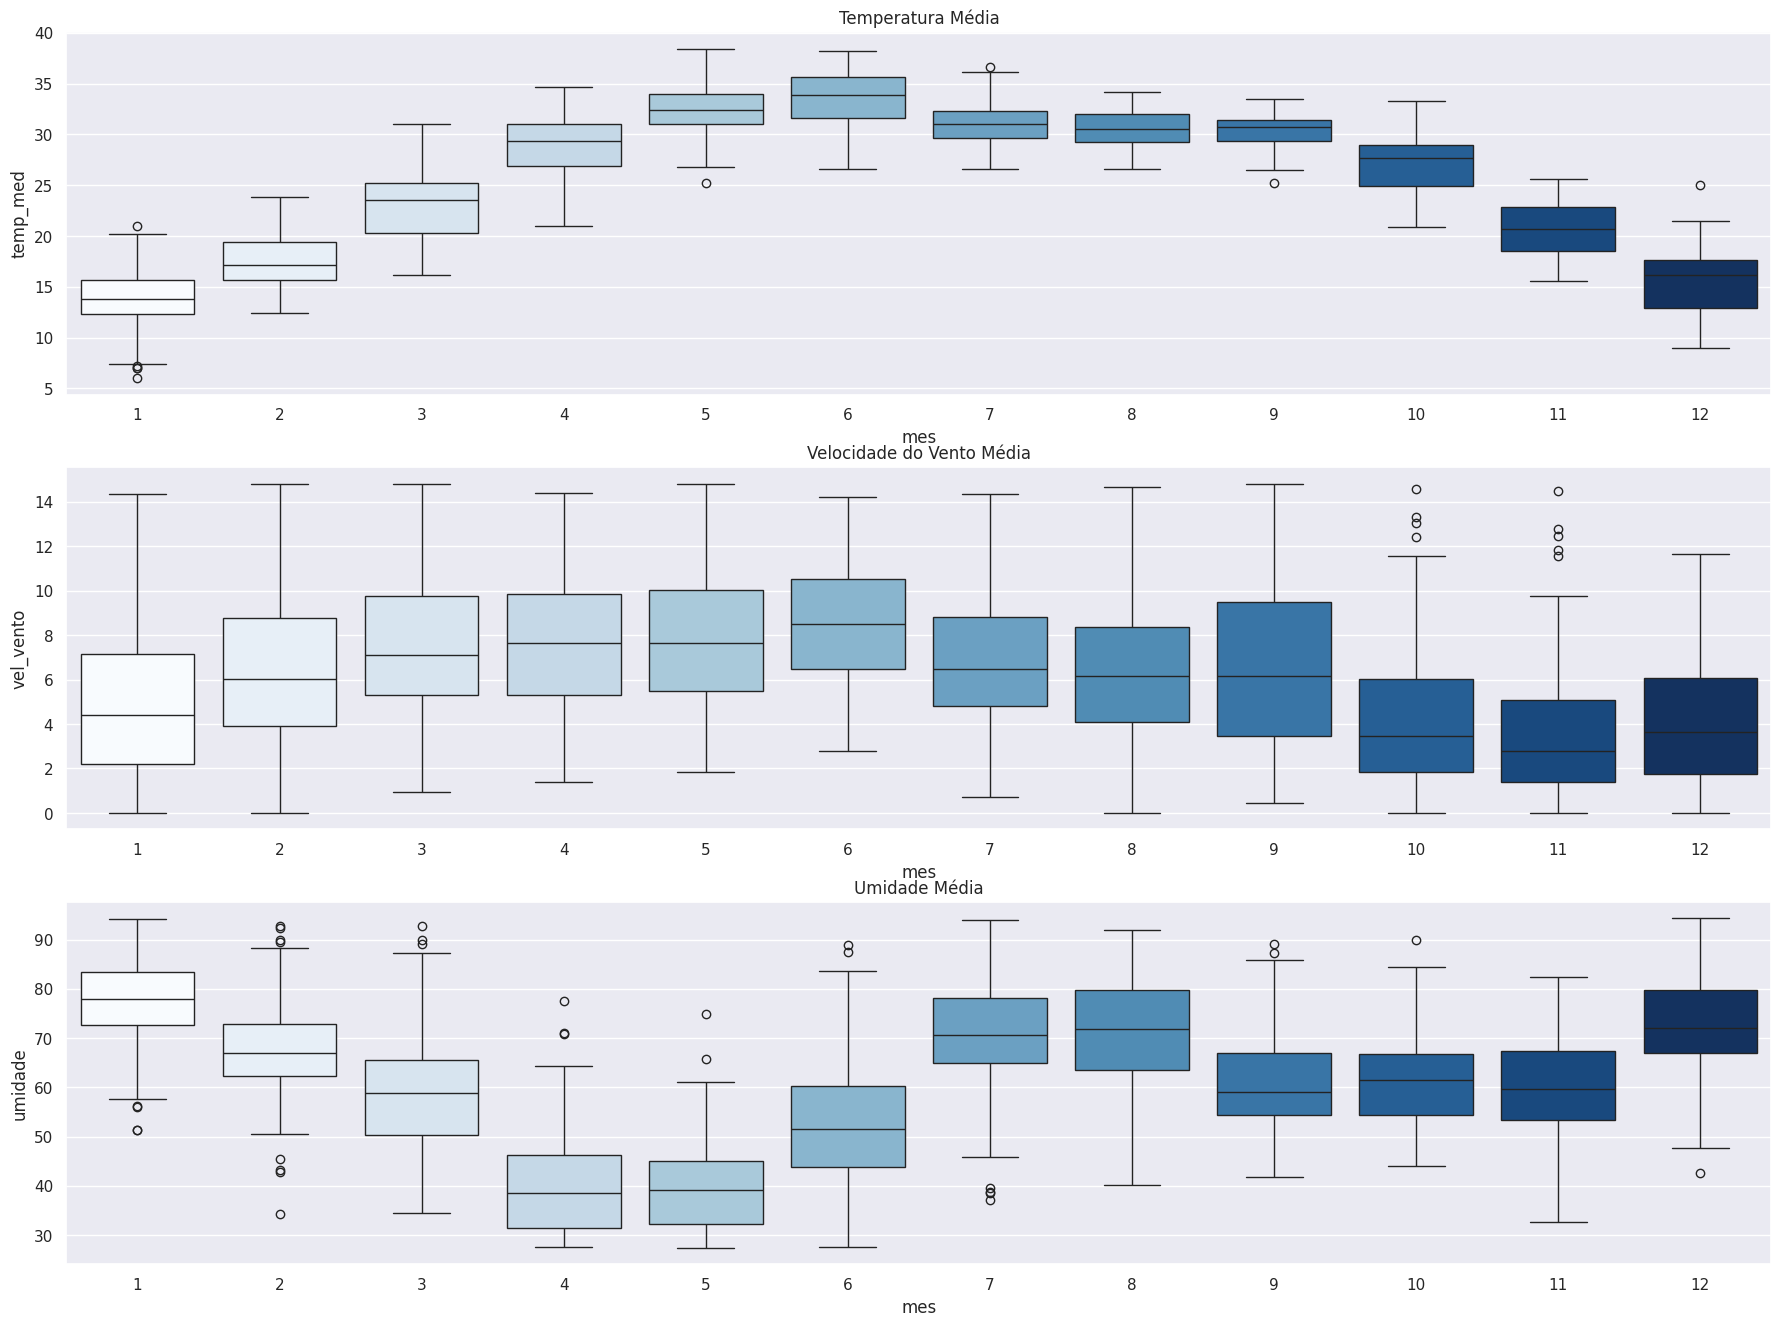

In [ ]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(22,16))

sns.set_theme(style='darkgrid')
sns.boxplot(x='mes', y='temp_med', data=db_daily_climate_iqr, hue='mes',palette='Blues', legend=False, ax=ax[0])
ax[0].set_title('Temperatura Média')

sns.boxplot(x='mes', y='vel_vento', data=db_daily_climate_iqr, hue='mes',palette='Blues', legend=False, ax=ax[1])
ax[1].set_title('Velocidade do Vento Média')

sns.boxplot(x='mes', y='umidade', data=db_daily_climate_iqr, hue='mes',palette='Blues', legend=False, ax=ax[2])
ax[2].set_title('Umidade Média')

plt.show()

In [ ]:
db_daily_climate_iqr_train = db_daily_climate_iqr.iloc[:round(len(db_daily_climate_iqr)*0.8)]
db_daily_climate_iqr_test = db_daily_climate_iqr[round(len(db_daily_climate_iqr)*0.8):]


arima_iqr_model = ARIMA(db_daily_climate_iqr_train['temp_med'], order=(2,1,1))
arima_iqr_model_fit = arima_iqr_model.fit()
print(arima_iqr_model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

                               SARIMAX Results                                
Dep. Variable:               temp_med   No. Observations:                 1147
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2196.368
Date:                Sun, 23 Mar 2025   AIC                           4400.736
Time:                        23:34:40   BIC                           4420.912
Sample:                             0   HQIC                          4408.353
                               - 1147                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4967      0.066      7.502      0.000       0.367       0.626
ar.L2         -0.0463      0.035     -1.339      0.180      -0.114       0.021
ma.L1         -0.7362      0.063    -11.765      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


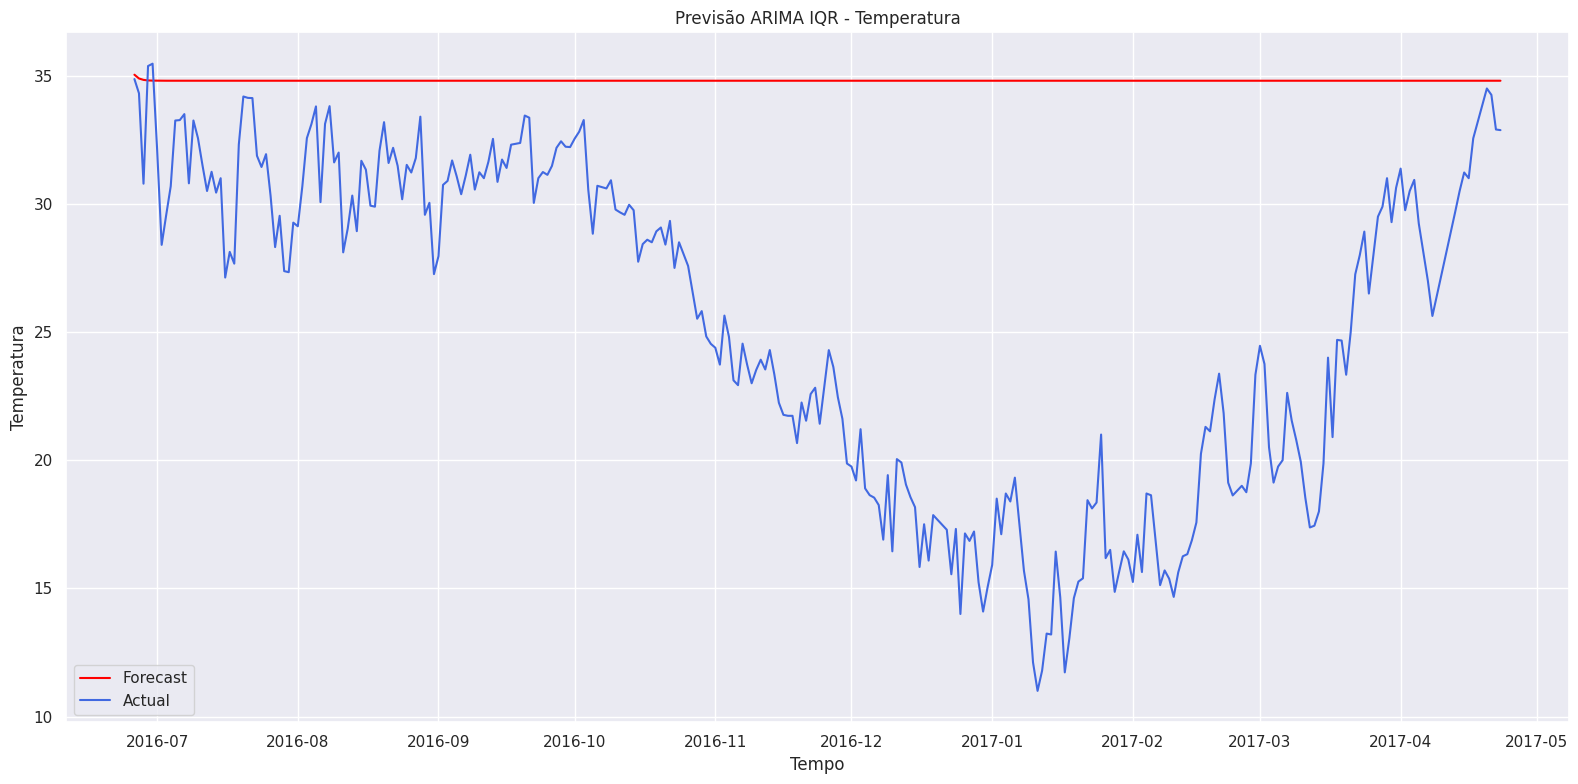

In [ ]:
previsoes_iqr_arima = arima_iqr_model_fit.forecast(steps=len(db_daily_climate_iqr_test))

mse_arima_iqr = mean_squared_error( db_daily_climate_iqr_test['temp_med'], previsoes_iqr_arima)
rmse_arima_iqr = np.sqrt(mse_arima_iqr)

fig = plt.figure(figsize=(16,8))

plt.plot(db_daily_climate_iqr_test.index, previsoes_iqr_arima, color='red', linestyle='-', label='Forecast')
plt.plot(db_daily_climate_iqr_test.index,db_daily_climate_iqr_test['temp_med'], color='royalblue', linestyle='-', label='Actual')
plt.title('Previsão ARIMA IQR - Temperatura')
plt.ylabel('Temperatura')
plt.xlabel('Tempo')
plt.legend()

plt.tight_layout()
plt.show()

##Modelo Holt-Winters

In [ ]:
db_daily_climate_train['data'] = pd.to_datetime(db_daily_climate_train.index)
db_daily_climate_train.set_index(db_daily_climate_train['data'], inplace=True)

db_daily_climate_test['data'] = pd.to_datetime(db_daily_climate_test.index)
db_daily_climate_test.set_index(db_daily_climate_test['data'], inplace=True)

<ipython-input-333-cc2b01784874>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_daily_climate_train['data'] = pd.to_datetime(db_daily_climate_train.index)
<ipython-input-333-cc2b01784874>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_daily_climate_test['data'] = pd.to_datetime(db_daily_climate_test.index)


In [ ]:
model_holt_winters = ExponentialSmoothing(db_daily_climate_train['temp_med'], trend='add', seasonal='add', seasonal_periods=365)
model_holt_winters_fit = model_holt_winters.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


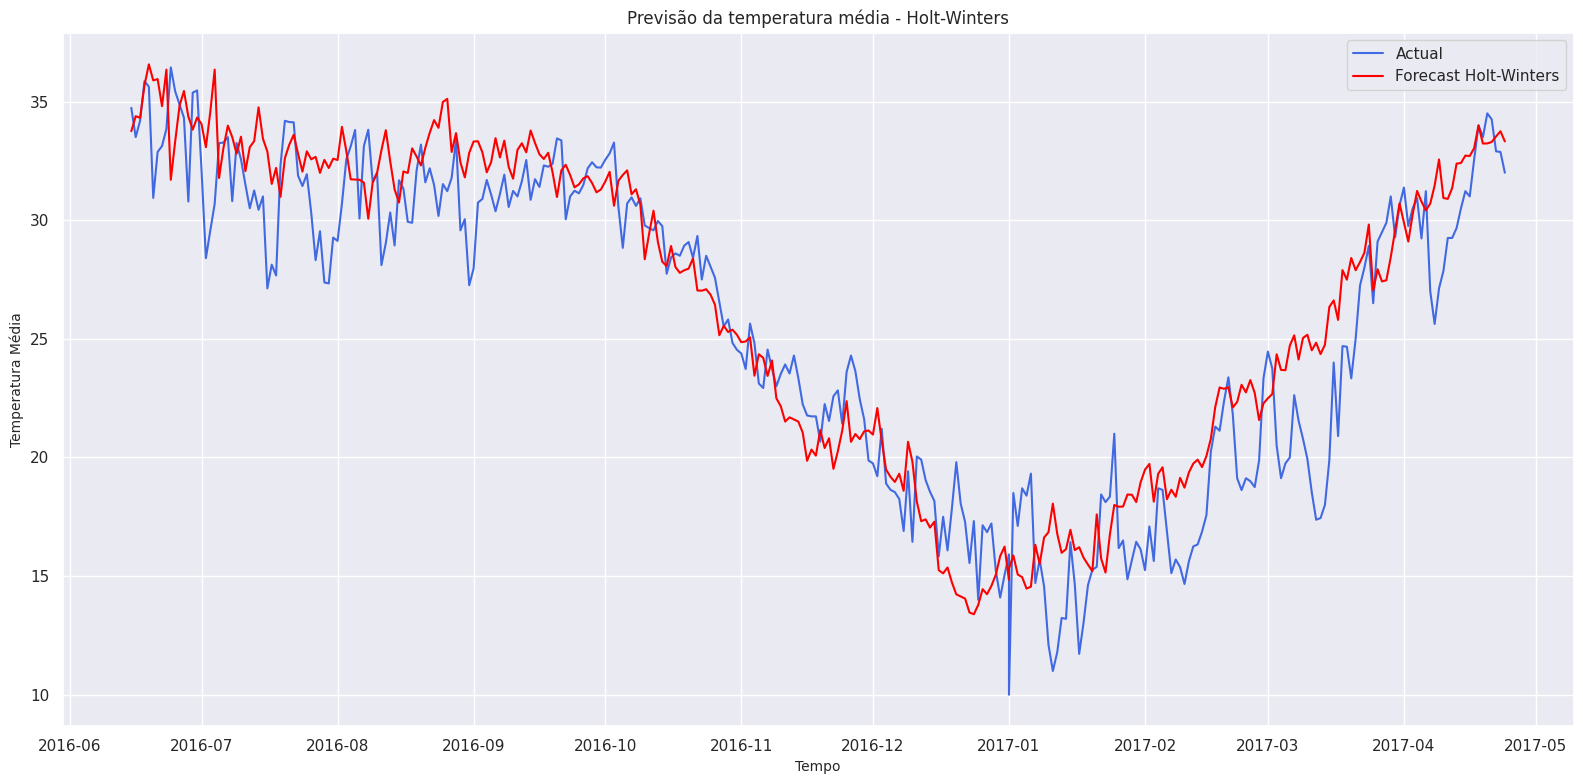

In [ ]:
previsao_holt_winters = model_holt_winters_fit.forecast(steps=len(db_daily_climate_test))

previsao_holt_winters = pd.DataFrame(previsao_holt_winters)
previsao_holt_winters.rename(columns={0:'temp_med'}, inplace=True)
previsao_holt_winters.set_index(db_daily_climate_test['data'],inplace=True)

fig = plt.figure(figsize=(16,8))

plt.plot(db_daily_climate_test.index, db_daily_climate_test['temp_med'], linestyle='-', color='royalblue', label='Actual')
plt.plot(db_daily_climate_test.index, previsao_holt_winters, linestyle='-', color='red', label='Forecast Holt-Winters')
plt.title("Previsão da temperatura média - Holt-Winters")
plt.ylabel("Temperatura Média", fontsize=10)
plt.xlabel("Tempo", fontsize=10)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
mse_holt_winters = mean_squared_error(previsao_holt_winters, db_daily_climate_test['temp_med'])
rmse_holt_winters = np.sqrt(mse_holt_winters)
print(f'MSE: {mse_holt_winters:.2f} | RMSE: {rmse_holt_winters:.2f}')

#Talvez para um modelo melhor, tentar usar IQR. O resultado acima aparenta estar sob influência de outlayer.

MSE: 6.71 | RMSE: 2.59


##RandomForest Regressor

###Multivariado

In [ ]:
db_daily_climate_train = db_daily_climate[:round(len(db_daily_climate)*0.8)].copy()
db_daily_climate_test = db_daily_climate[round(len(db_daily_climate)*0.8):].copy()

x_train, x_unused, y_train, y_unused = train_test_split(db_daily_climate_train.drop(columns=['temp_med'], axis=1), db_daily_climate_train['temp_med'], test_size=0.2, random_state=42)

x_test = db_daily_climate_test.drop('temp_med',axis=1)
y_test = db_daily_climate_test['temp_med']

modelo_randomforest = RandomForestRegressor(n_estimators=500, min_samples_leaf=10, max_depth=20, random_state=21, n_jobs=-1)
modelo_randomforest.fit(x_train, y_train)

previsao_randomforest_mult = modelo_randomforest.predict(x_test)

mse_randomforest_mult = mean_squared_error(previsao_randomforest_mult, y_test)
rmse_randomforest_mult = np.sqrt(mse_randomforest_mult)

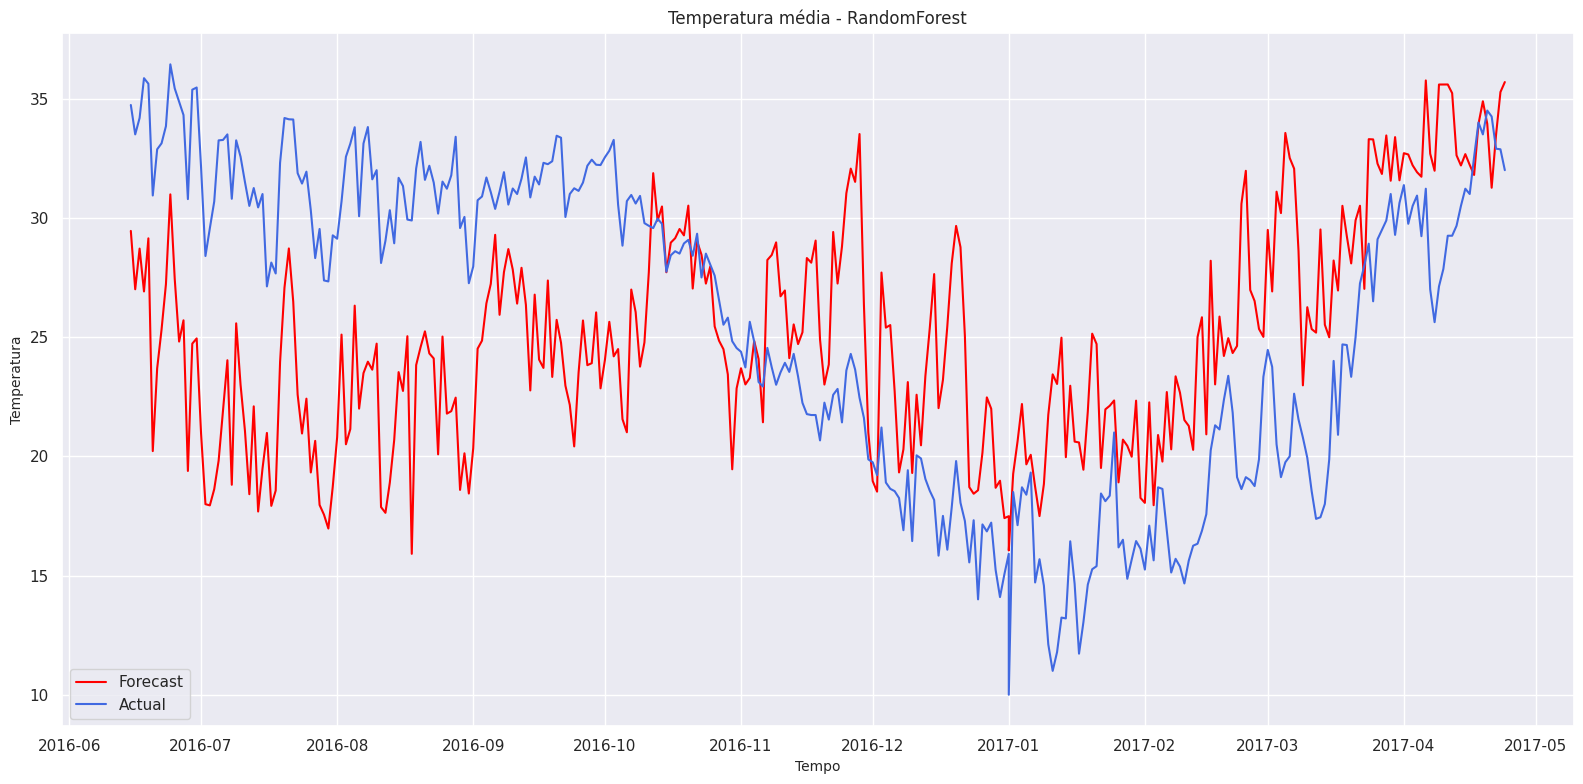

In [ ]:
previsao_randomforest_mult = pd.DataFrame(previsao_randomforest_mult)
previsao_randomforest_mult.rename(columns={0:'temp_med'},inplace=True)
previsao_randomforest_mult.set_index(y_test.index, inplace=True)

fig = plt.figure(figsize=(16,8))

plt.plot(previsao_randomforest_mult.index, previsao_randomforest_mult, linestyle='-', color='red', label='Forecast')
plt.plot(y_test.index, y_test, linestyle='-', color='royalblue', label='Actual')
plt.title('Temperatura média - RandomForest', fontsize=12)
plt.xlabel('Tempo', fontsize=10)
plt.ylabel('Temperatura', fontsize=10)
plt.legend()

plt.tight_layout()
plt.show()

#Após diversas tentativas de estabilizar o modelo (sem utiliação de cross-validation e outros métodos), o modelo RandomForest Regressor multivariado não apresentou resultados tão satisfatórios quanto holt-winters.

###Univariado

In [ ]:
db_daily_climate_train = db_daily_climate[:round(len(db_daily_climate)*0.8)]
db_daily_climate_test = db_daily_climate[round(len(db_daily_climate)*0.8):]

def coluna_lag(data, lag=1):
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:i+lag])
        y.append(data[i+lag])
    return np.array(X), np.array(y)

lag = 2
x_train, y_train = coluna_lag(db_daily_climate_train["temp_med"].values, lag=lag)
x_test, y_test = coluna_lag(db_daily_climate_test["temp_med"].values, lag=lag)
x_train = x_train.reshape(-1, lag)
x_test = x_test.reshape(-1, lag)

#Modelo:
modelo_randomforest_uni = RandomForestRegressor(n_estimators=100, min_samples_split=10, min_samples_leaf=5, random_state=42)
modelo_randomforest_uni.fit(x_train, y_train)

#Forecast
previsao_randomforest_uni = modelo_randomforest_uni.predict(x_test)
y_train_pred = modelo_randomforest_uni.predict(x_train)

#Erro:
#Teste:
mse_randomforest_uni = mean_squared_error(previsao_randomforest_uni, y_test)
rmse_randomforest_uni = np.sqrt(mse_randomforest_uni)
#Treino
mse_train =mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

print(f'Erro no Treino: {rmse_train:.2f}')
print(f'Erro no Teste: {rmse_randomforest_uni:.2f}')

Erro no Treino: 1.37
Erro no Teste: 1.71


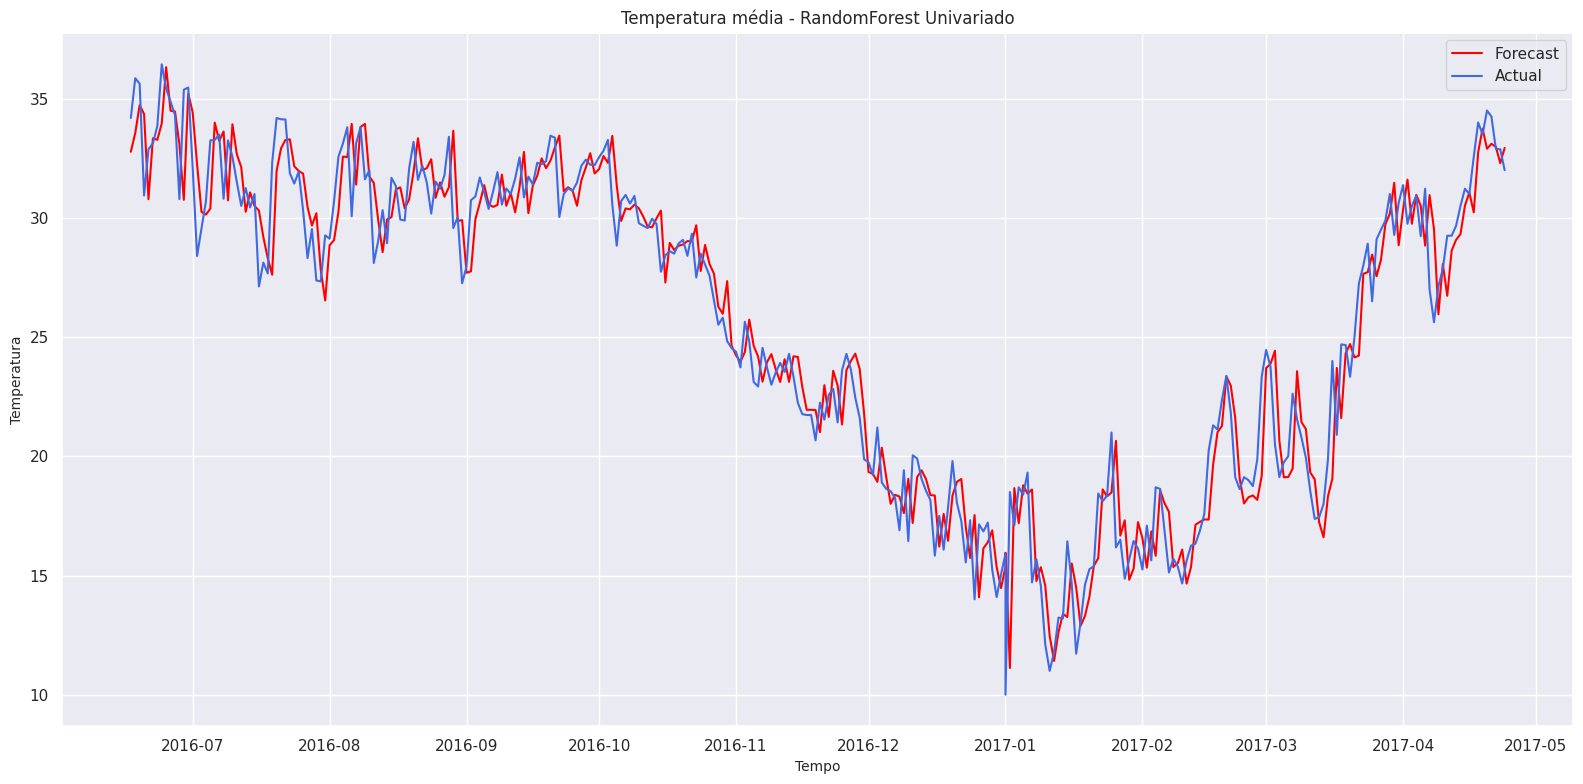

In [ ]:
db_dct_temp = db_daily_climate[round(len(db_daily_climate)*0.8):]
db_dct_temp = db_dct_temp['temp_med'].iloc[lag:]

previsao_randomforest_uni = pd.DataFrame(previsao_randomforest_uni)
previsao_randomforest_uni.rename(columns={0:'temp_med'},inplace=True)
previsao_randomforest_uni.set_index(db_dct_temp.index, inplace=True)

fig = plt.figure(figsize=(16,8))

plt.plot(previsao_randomforest_uni.index, previsao_randomforest_uni, linestyle='-', color='red', label='Forecast')
plt.plot(db_dct_temp.index, db_dct_temp, linestyle='-', color='royalblue', label='Actual')
plt.title('Temperatura média - RandomForest Univariado', fontsize=12)
plt.xlabel('Tempo', fontsize=10)
plt.ylabel('Temperatura', fontsize=10)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
db_transf_naive_mod = db_daily_climate.iloc[round(len(db_daily_climate) * 0.8):].copy()

db_naive_mod = db_transf_naive_mod[['temp_med']].copy()
db_naive_mod['lag_1'] = db_naive_mod['temp_med'].shift(1)

db_naive_mod = db_naive_mod.iloc[3:]

mse_naive_forecast = mean_squared_error(db_naive_mod['temp_med'], db_naive_mod['lag_1'])
rmse_naive_forecast = np.sqrt(mse_naive_forecast)
print(f'RMSE Naive Bayes: {rmse_naive_forecast:.4f}')

RMSE Naive Bayes: 1.7027


In [ ]:
corr_forecast_naive  = previsao_randomforest_uni['temp_med'].corr(db_naive_mod['lag_1'])
print(f'Correlação entre modelo Naive Bayes e RandomForestRegressor: {corr_forecast_naive:.4f}')

#Por ser praticamente iguais, porém com "atrasos" nas previsões e, também, dado as estatísticas quase identicas de RMSE além da correlação entre ambos ser quase perfeita, entendemos que o modelo está enviesado devido a ideia utilizada de lag. Um modelo RanfomForest Regressor "univariado" não parece atender a casos como esse.

Correlação entre modelo Naive Bayes e RandomForestRegressor: 0.9962


#Conclusão

In [ ]:
#ARIMA
print('-----------------------------------------------------------------')
print(f'| ARIMA(2,1,2) Multivariado | MSE: {mse_arima_mult:.2f} | RMSE: {rmse_arima_mult:.2f}')
print('-----------------------------------------------------------------')
print(f'| ARIMA(2,1,1) Univariado | MSE: {mse_arima_uni:.2f} | RMSE: {rmse_arima_uni:.2f}')
#ARIMA Z-SCORE e IQR
print('-----------------------------------------------------------------')
print(f'| ARIMA(1,1,2) com Z-Score Univariado | MSE: {mse_arima_zscore:.2f} | RMSE: {rmse_arima_zscore:.2f}')
print('-----------------------------------------------------------------')
print(f'| ARIMA(2,1,1) com IRQ Univariado | MSE: {mse_arima_iqr:.2f} | RMSE: {rmse_arima_iqr:.2f}')
#Holt-Winters
print('-----------------------------------------------------------------')
print(f'| Modelo Holt-Winters | MSE: {mse_holt_winters:.2f} | RMSE: {rmse_holt_winters:.2f}')
#Random-Forest Regressor
print('-----------------------------------------------------------------')
print(f'| Modelo RandomForest Multivariado | MSE: {mse_randomforest_mult:.2f} | RMSE: {rmse_randomforest_mult:.2f}')
print('-----------------------------------------------------------------')
print(f'| Modelo RandomForest Univariado | MSE: {mse_randomforest_uni:.2f} | RMSE: {rmse_randomforest_uni:.2f}')
print('-----------------------------------------------------------------')

-----------------------------------------------------------------
| ARIMA(2,1,2) Multivariado | MSE: 205.64 | RMSE: 14.34
-----------------------------------------------------------------
| ARIMA(2,1,1) Univariado | MSE: 117.54 | RMSE: 10.84
-----------------------------------------------------------------
| ARIMA(1,1,2) com Z-Score Univariado | MSE: 290.97 | RMSE: 17.06
-----------------------------------------------------------------
| ARIMA(2,1,1) com IRQ Univariado | MSE: 134.94 | RMSE: 11.62
-----------------------------------------------------------------
| Modelo Holt-Winters | MSE: 6.71 | RMSE: 2.59
-----------------------------------------------------------------
| Modelo RandomForest Multivariado | MSE: 46.89 | RMSE: 6.85
-----------------------------------------------------------------
| Modelo RandomForest Univariado | MSE: 2.92 | RMSE: 1.71
-----------------------------------------------------------------


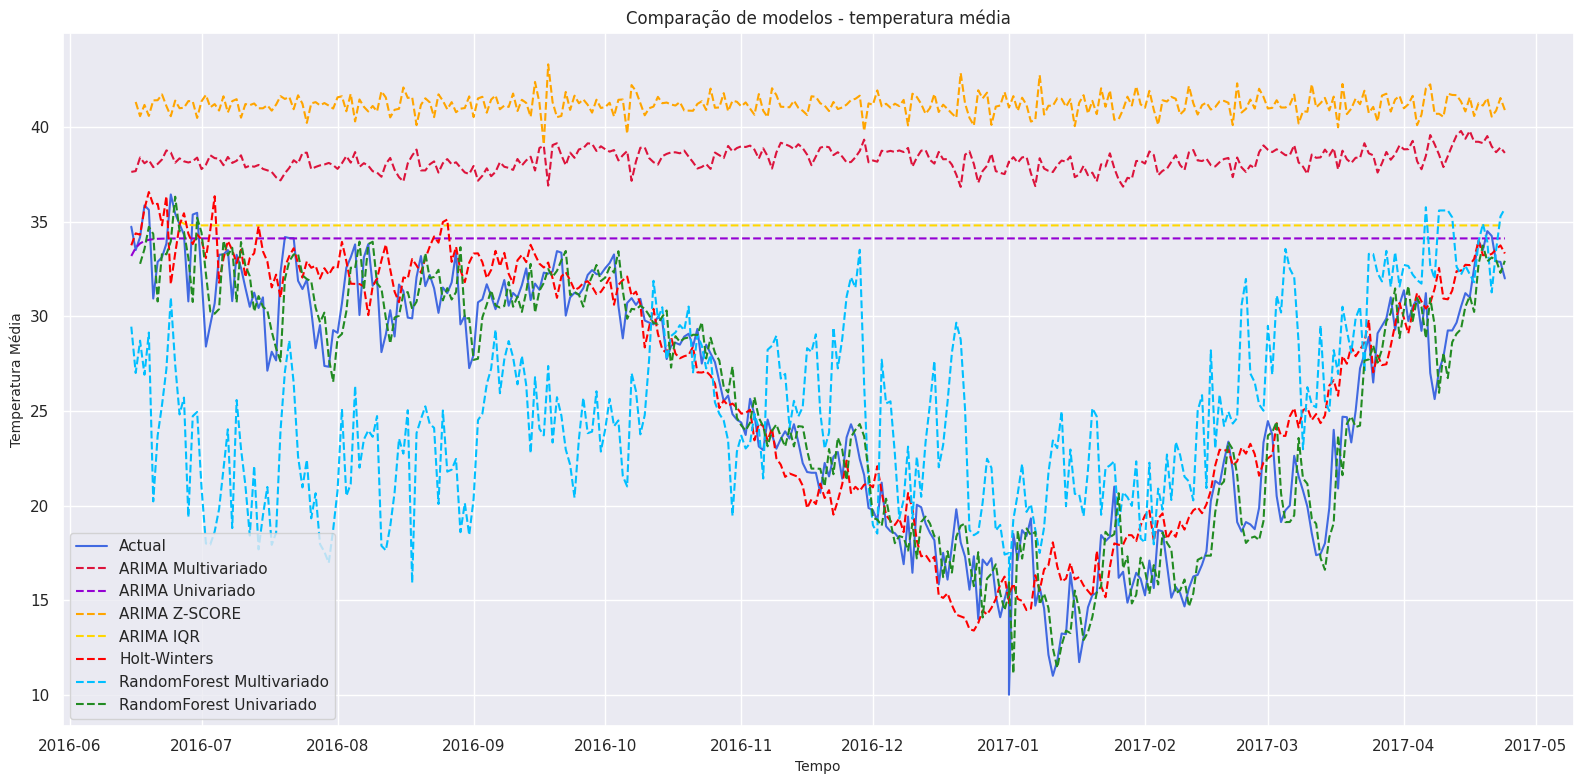

In [ ]:
fig = plt.figure(figsize=(16,8))

plt.plot(db_daily_climate_test.index, db_daily_climate_test['temp_med'], linestyle='-', color='royalblue', label='Actual')
plt.plot(db_daily_climate_test.index, previsao_arima_mult, linestyle='--', color='crimson', label='ARIMA Multivariado')
plt.plot(db_daily_climate_test.index, previsao_arima_uni, linestyle='--', color='darkviolet', label='ARIMA Univariado')
plt.plot(previsao_arima_zscore.index, previsao_arima_zscore, linestyle='--', color='orange', label='ARIMA Z-SCORE')
plt.plot(db_daily_climate_iqr_test.index, previsoes_iqr_arima, linestyle='--', color='gold', label='ARIMA IQR')
plt.plot(db_daily_climate_test.index, previsao_holt_winters, linestyle='--', color='red', label='Holt-Winters')
plt.plot(db_daily_climate_test.index, previsao_randomforest_mult, linestyle='--', color='deepskyblue', label='RandomForest Multivariado')
plt.plot(previsao_randomforest_uni.index, previsao_randomforest_uni, linestyle='--', color='forestgreen', label='RandomForest Univariado')

plt.title("Comparação de modelos - temperatura média")
plt.ylabel("Temperatura Média", fontsize=10)
plt.xlabel("Tempo", fontsize=10)
plt.legend()

plt.tight_layout()
plt.show()

Podemos concluir que, com as estatísticas apresentadas, o melhor modelo dentre os aqui apresentados para os dados estudados é o modelo Holt-Winters, do qual, obteve a melhor previsão e RMSE (raiz quadrada média).

Apesar do modelo RandomForest Univariado apresentar melhores estatísticas, entendemos que seus valores são enviesados, uma vez que o modelo pode ter buscado um padrão através dos lags. Chegamos a esta conclusão a partir do gráfico, onde é possível verificar que o modelo aparenta prever os dados com alguns períodos de distância.

Apesar disso, através deste case conseguimos aprender mais sobre técnicas de tratamento de outlayers, além de novos modelos como Holt-Winters e, por fim, estudar mais sobre a confecção de gráficos e manipulação de variáveis.